# Исследовательский анализ компьютерных игр

В данном исследовании рассмотрены игры, произведенные в 1980-2016 годах на различных платформах. В исследовании данные по нескольким регионам - Северная Америка, Европа, Япония и др.   
Цель исследования - понять, есть ли взаимосвязь между объёмами продаж и платформой, жанром, регионом, оценкой критиков, рейтингом игры; спрогнозировать прибыльные платформы на 2017 год; дать рекомендации по выбору параметров для успешного создания игры.

## ОБЩАЯ ИНФОРМАЦИЯ

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
try:
    games = pd.read_csv('/datasets/games.csv')
except:
    games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
games

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


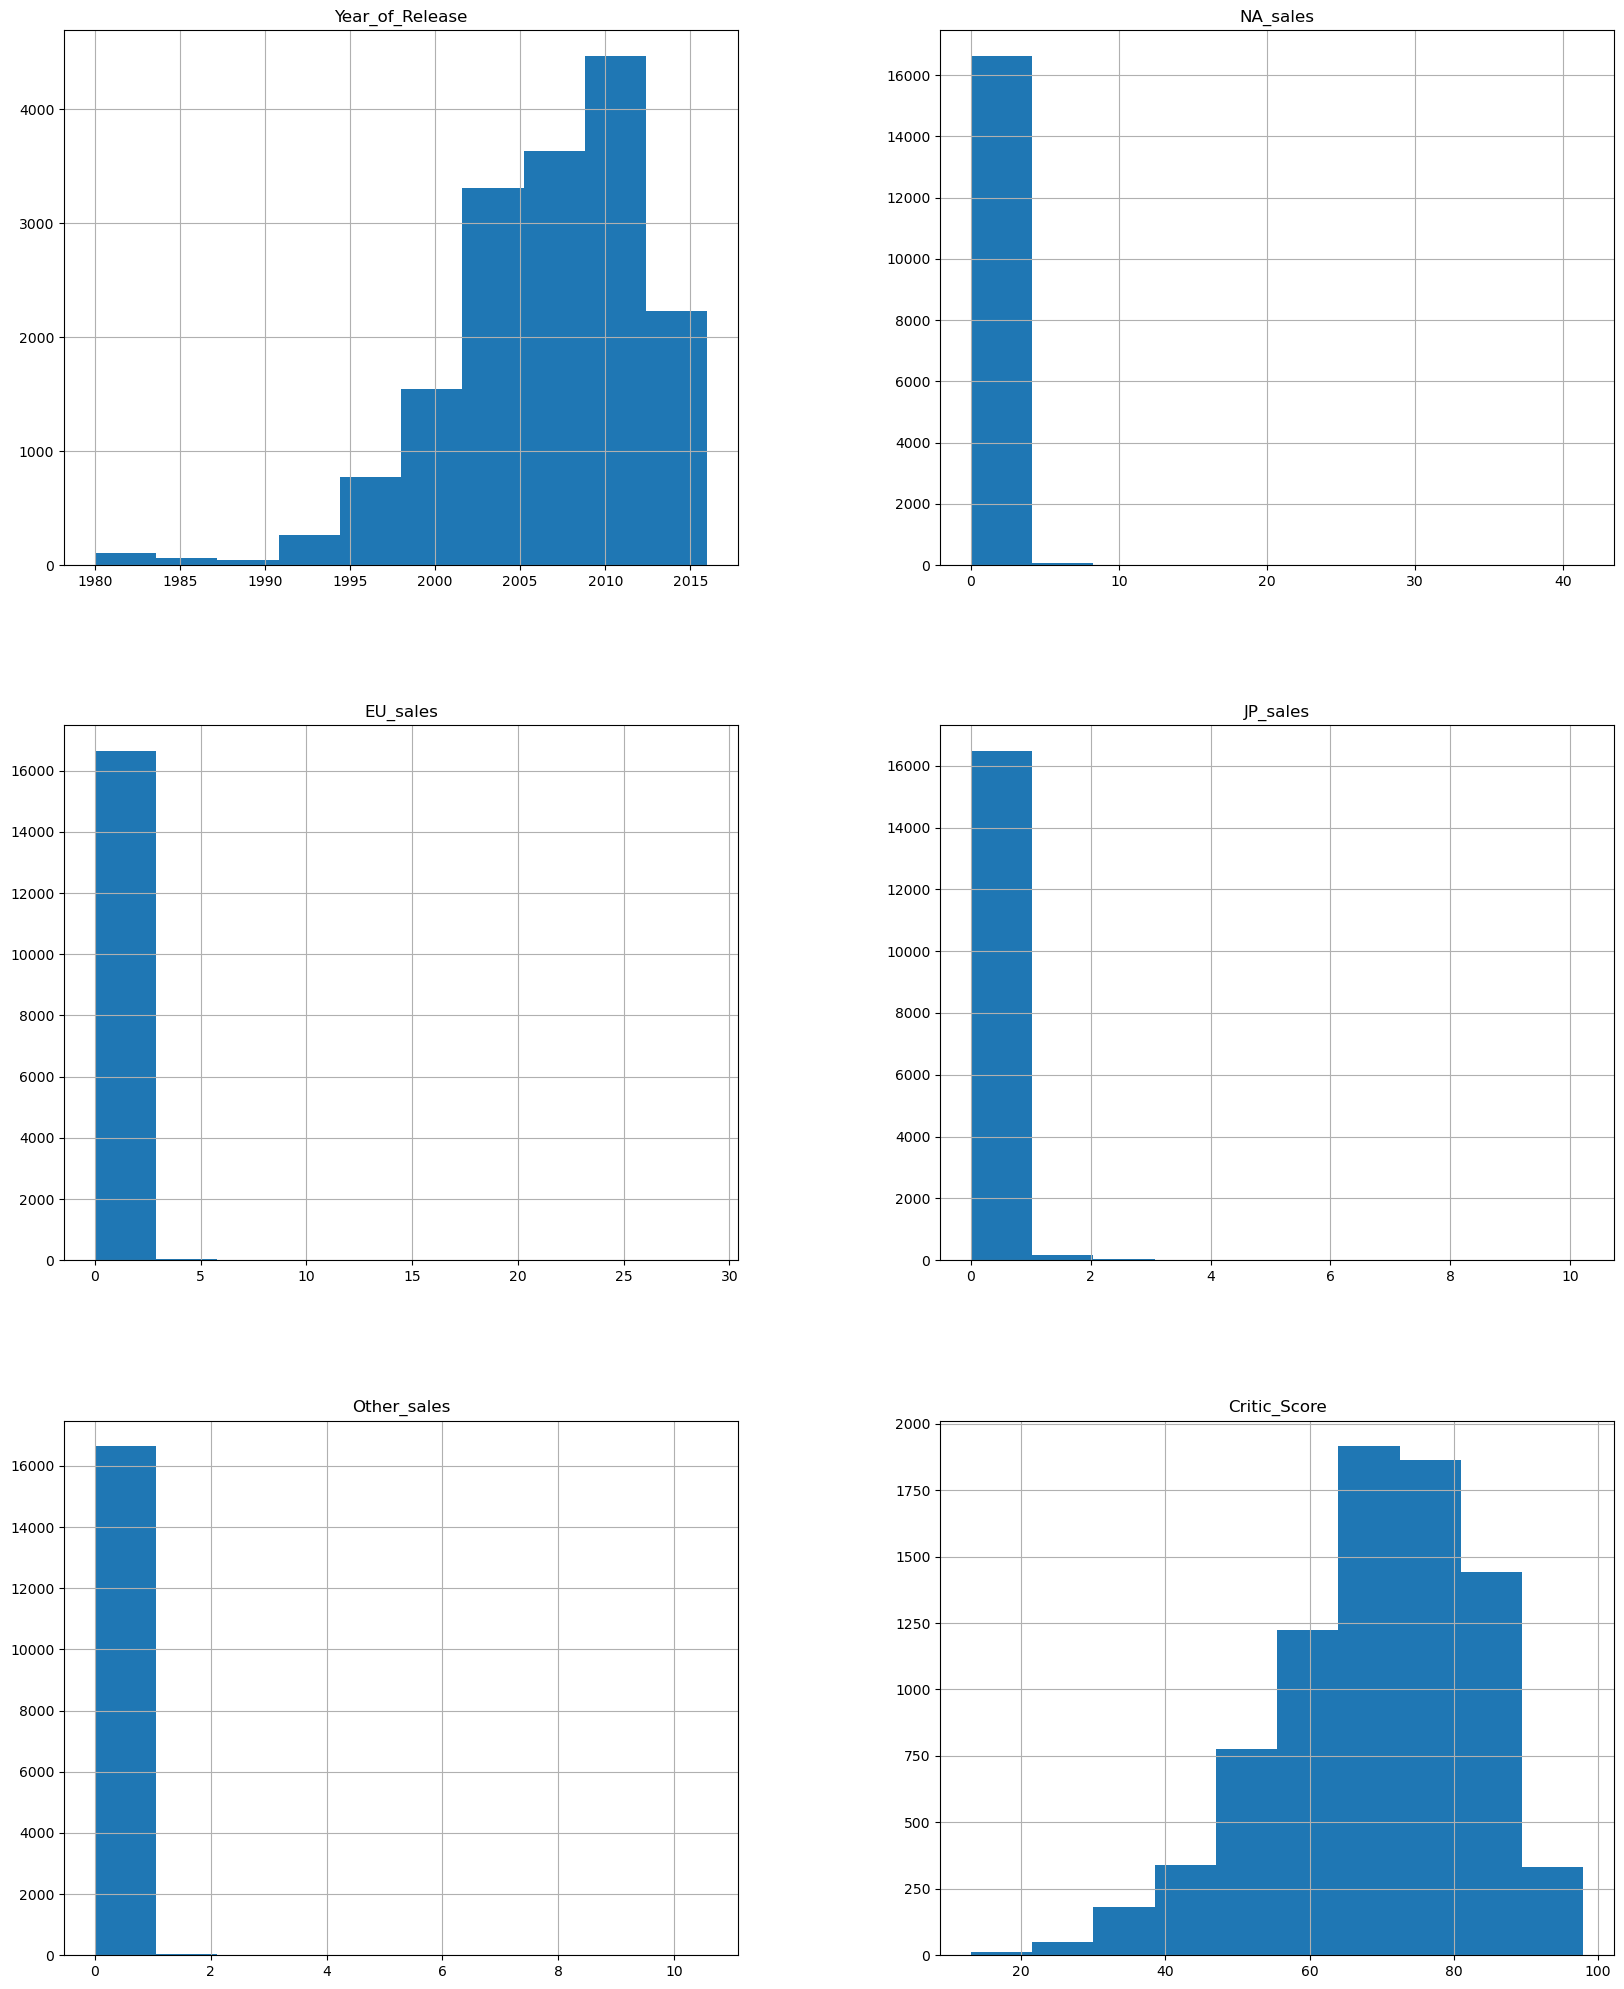

In [4]:
games.hist(figsize=(20, 25));

Краткое описание данных:
- с 1990-х годов количество произведенных игр в разы увеличилось, пик приходится на 2010-е, далее до 2016 сильный спад 
- лидерами продаж является Северная Америка, затем, Европа и меньше всего продаж в Японии (другие страны в сумме сравнимы с продажами в Японии)
- средняя оценка игр критиками 65-85 баллов из ста.

Остальные данные переведем в верный формат и рассмотрим далее.

## ПОДГОТОВКА ДАННЫХ

### Общий вид

Приведем название столбцов к хорошему тону:

In [5]:
games.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [6]:
games.columns = games.columns.str.lower()

Преобразуем данные в нужный тип:

Значение в столбце год выпуска округлим до целых (год - это целое число).

In [7]:
games['year_of_release'] = games['year_of_release'].astype('Int64')

Проверим корректность диапазона - все правильно.

In [8]:
sorted(games[~games['year_of_release'].isna()]['year_of_release'].unique())

[1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]

In [9]:
games.duplicated().sum()

0

Явных дубликатов строк нет.

### tbd

При попытке отформатировать столбец с рейтингом пользователей, наткнулись на значение tbd (to be determined). Сложно сказать, чем оно обусловлено, можно было бы предположить, что игры свежие и рейтинг еще не определен до конца, но из проверки ниже видим, что такие пропуски появляются с 1999 года. Переведем его в пустые значения, а затем изменим формат данных на числовой, чтобы с ним можно было работать.

In [10]:
games.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [11]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [12]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

In [13]:
games['user_score'] = games['user_score'].astype('float')

In [14]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [15]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [16]:
games['rating'].isna().value_counts()

False    9949
True     6766
Name: rating, dtype: int64

В рейтинге ESRB категориальные значения.  
Почти треть данных не заполнена, также есть рейтинг RP - не определен, который приравняем к пустым значениям.  
Для дальнейшей работы с данными все пустые значения рейтингов заменим на "missing".

In [17]:
games.loc[(games['rating'] == 'RP') | (games['rating'].isna()), 'rating'] = 'missing'

In [18]:
games['rating'].value_counts()

missing    6769
E          3990
T          2961
M          1563
E10+       1420
EC            8
K-A           3
AO            1
Name: rating, dtype: int64

Теперь мы видим данные с отсутствующим рейтингом.

### Пропуски

Две строки с пропущенным названием игр и жанром удалим, поскольку в данных без названия игры нет смысла.

In [19]:
games.loc[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,missing
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,missing


In [20]:
games = games.dropna(subset=['name']).reset_index(drop=True) 

Посмотрим на пропуски в годах выпуска игр.

In [21]:
games.shape

(16713, 11)

In [22]:
games.loc[games['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,missing
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,missing
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16403,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,missing


In [23]:
len(games.name.unique())

11559

Из 269 пропущенных значений большая часть строк с играми не повторяется, исходя из количества уникальных игр в датафрейме. Их замена с помощью поиска одноименных игр с заполненным годом выпуска займет слишком много времени и ресурсов. Поскольку пропусков менее 2%, мы удалим эти строки, чтобы не искажать данные.

In [24]:
games = games.loc[~games['year_of_release'].isna()]

Пропуски в последних трех столбцах мы не можем вычислить или заполнить на что-то логичное, также их слишом много, чтобы удалить, оставляем как есть. Пропуски в этих столбцах часто пересекаются в одних и тех же строках (возможно, это связано с системой рейтингов, например, не все игры через неё проходят).

In [25]:
games.loc[games['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,missing
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,missing
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,missing
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,missing
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,missing
...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,missing
16709,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,missing
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,missing
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,missing


### Суммарные продажи по регионам

Добавим столбец для суммарных продаж по регионам

In [26]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games = games.reindex(columns=['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'total_sales', 'critic_score', 'user_score', 'rating'])
games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,missing
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,missing
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0.01,NaN,NaN,missing
16709,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,0.01,NaN,NaN,missing
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.01,NaN,NaN,missing
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,0.01,NaN,NaN,missing


## ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

### Выпуск игр по годам

Посмотрим сколько игр выпускалось каждый год.

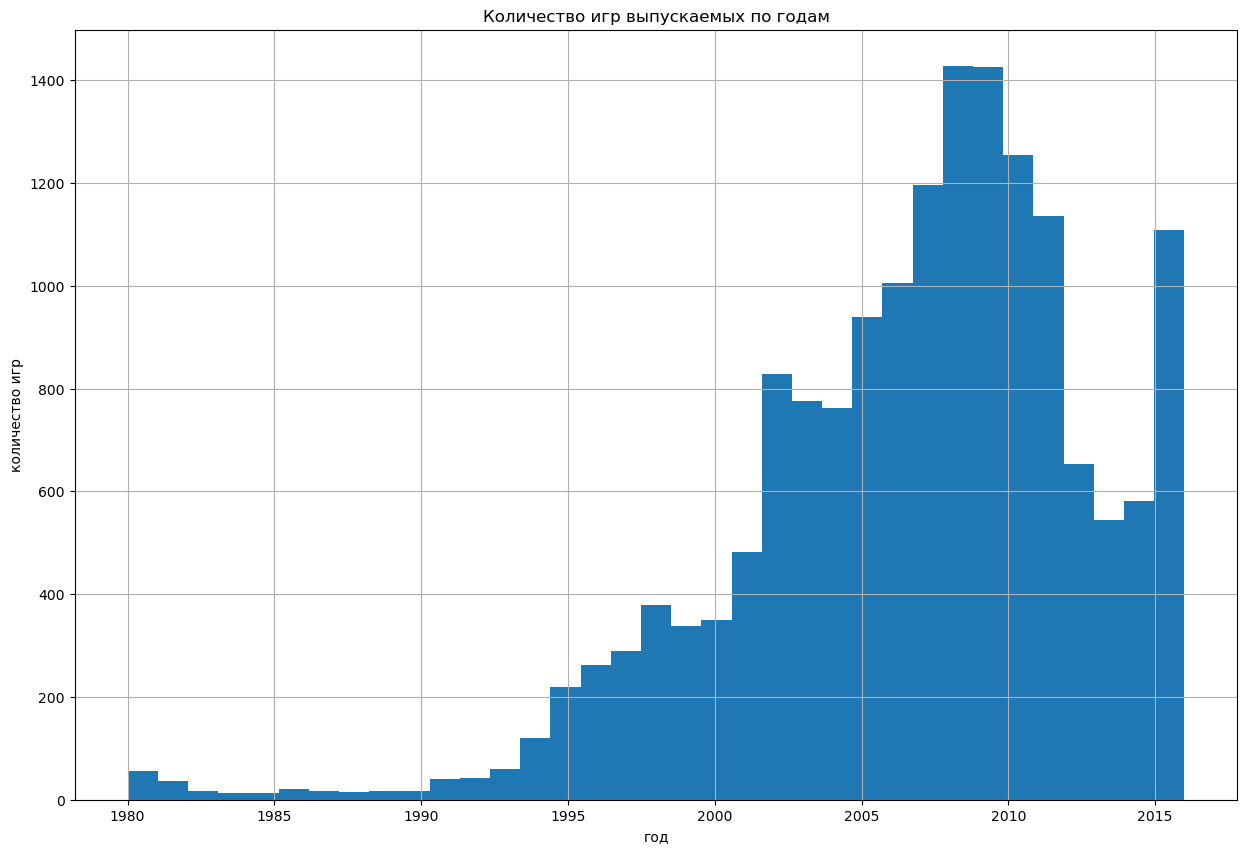

In [27]:
games.year_of_release.hist(bins=35, figsize=(15, 10))
plt.title('Количество игр выпускаемых по годам')
plt.xlabel('год')
plt.ylabel('количество игр')
plt.show()

In [28]:
games.year_of_release.value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: Int64

До 1994 года выпускалось менее 70 игр в год, анализировать даные в эти года не корректно. Обновим диапазон датафрейма с 1994 до 2016 (удалим 5% строк).

In [29]:
games['year_of_release'] = games['year_of_release'].astype(int)

In [30]:
games = games.query('year_of_release > 1993')

### Платформы

Посмотрим на разнообразие платформ по годам. Видим, что до 2009 количество платформ увеличивается, после - падает. Возможно, к этому моменту сформировались наиболее популярные или универсальные платформы.

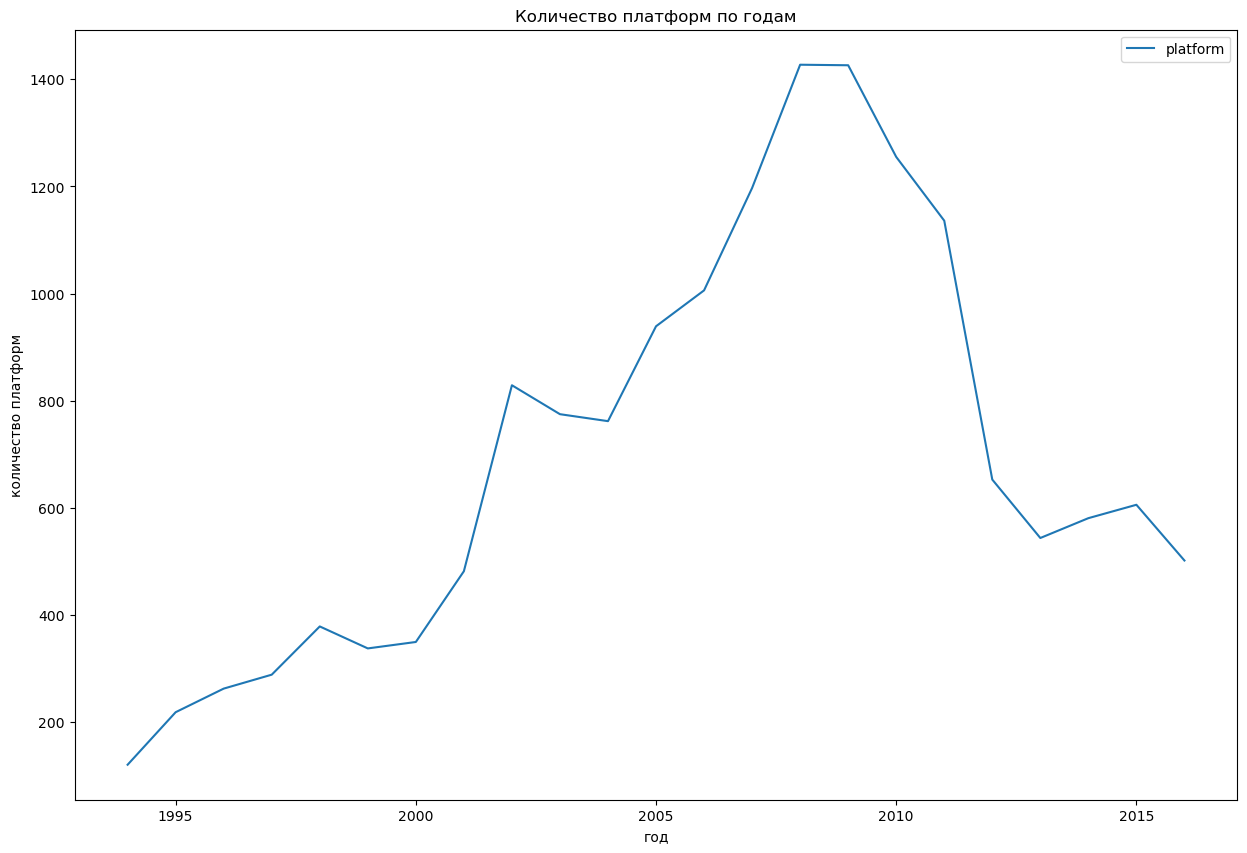

In [31]:
games.pivot_table(index='year_of_release', values='platform', aggfunc='count').plot(figsize=(15, 10))
plt.title('Количество платформ по годам')
plt.xlabel('год')
plt.ylabel('количество платформ')
plt.show()

Топ 10 популярных платформ:

In [32]:
games.platform.value_counts().head(10)

PS2     2127
DS      2120
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       950
GBA      811
XB       803
Name: platform, dtype: int64

На первых местах: Sony PlayStation (2,3), Nintendo DS, Xbox 360 от Microsoft.

Посмотрим на количество игр по годам:

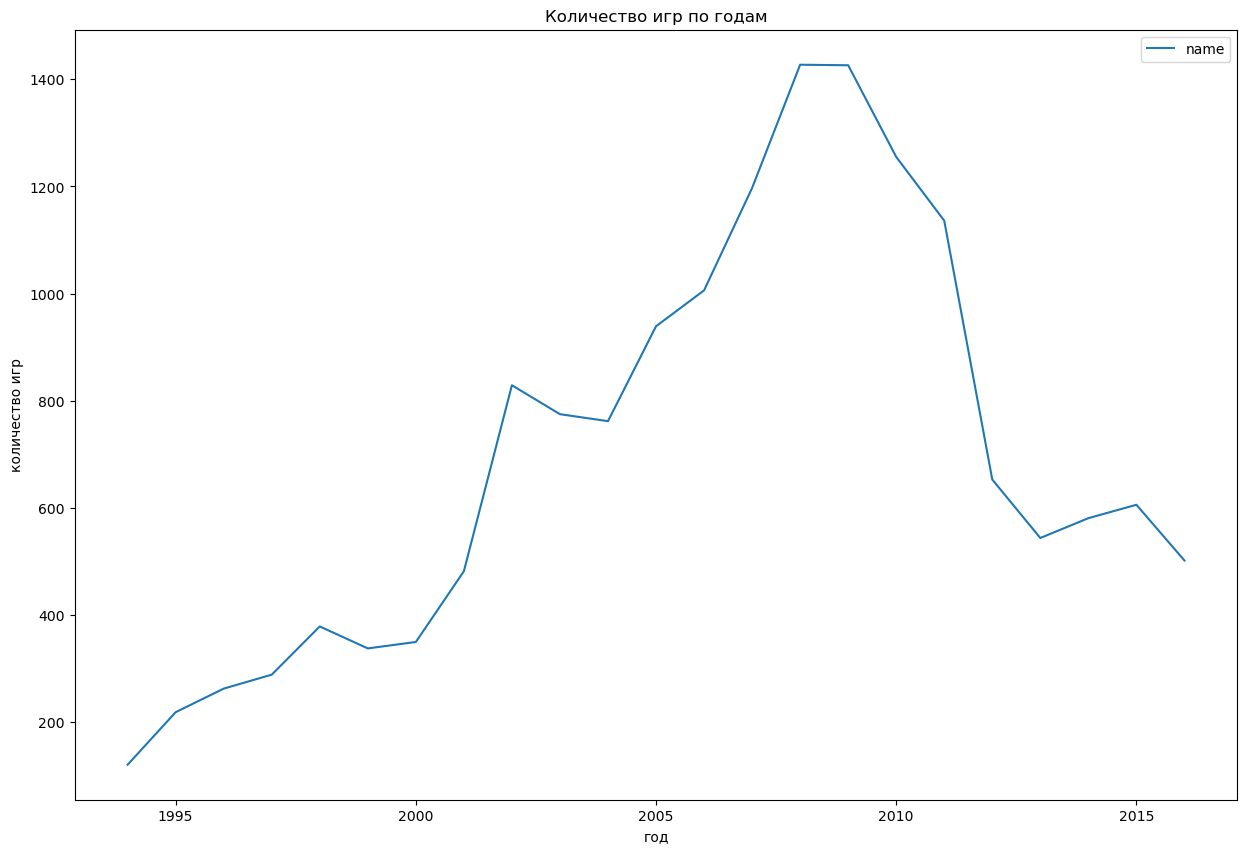

In [33]:
games.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(figsize=(15, 10))
plt.title('Количество игр по годам')
plt.xlabel('год')
plt.ylabel('количество игр')
plt.show()

In [34]:
games.pivot_table(index='year_of_release', values='name', aggfunc='count')

,name
year_of_release,
1994,121
1995,219
1996,263
1997,289
1998,379
1999,338
2000,350
2001,482
2002,829


С 2010 года количество игр и платформ пошло на спад.

Построим аналогичный график для платформ с наибольшим количеством суммарных продаж. Возьмем топ шесть (наиболее отличающиеся от остальных).

In [35]:
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(6)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       727.58
Name: total_sales, dtype: float64

In [36]:
top_platforms = games.query('platform == ["PS2", "X360", "PS3", "Wii", "DS", "PS"]')

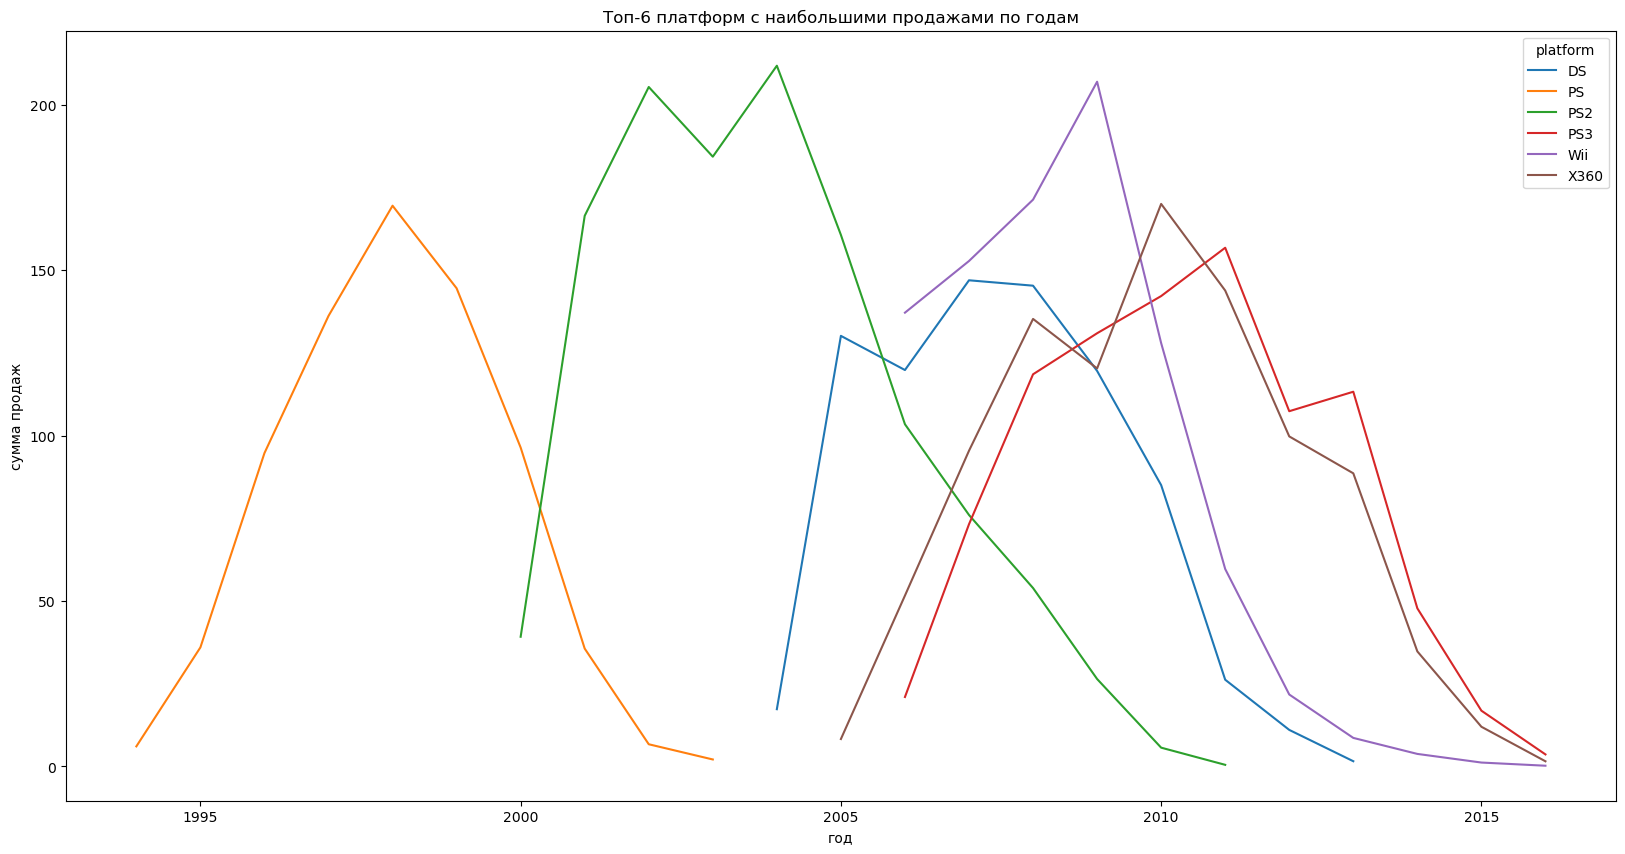

In [37]:
(top_platforms.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(20, 10)))
plt.title('Топ-6 платформ с наибольшими продажами по годам')
plt.xlabel('год')
plt.ylabel('сумма продаж')
plt.show()

Мы видим, что достаточно продолжительное время лидирующую позицию занимала компания Sony, каждая версия PlayStation которой выходила закономерно после спада предыдущей (в отличие, например, от Nintendo, она выпустила две платформы с разницой всего лишь в 2 года и на пике продаж первой).

Оценим продолжительность жизни топовых платформ:

In [38]:
top_platforms_life = top_platforms.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
top_platforms_life.columns = ['release', 'end']
top_platforms_life['life'] = top_platforms_life.end - top_platforms_life.release
top_platforms_life.sort_values(by='release')

,release,end,life
platform,,,
PS,1994,2003,9
PS2,2000,2011,11
DS,2004,2013,9
X360,2005,2016,11
PS3,2006,2016,10
Wii,2006,2016,10


**В среднем, топовые платформы живут 10 лет.**

Взглянем на график всех платформ.

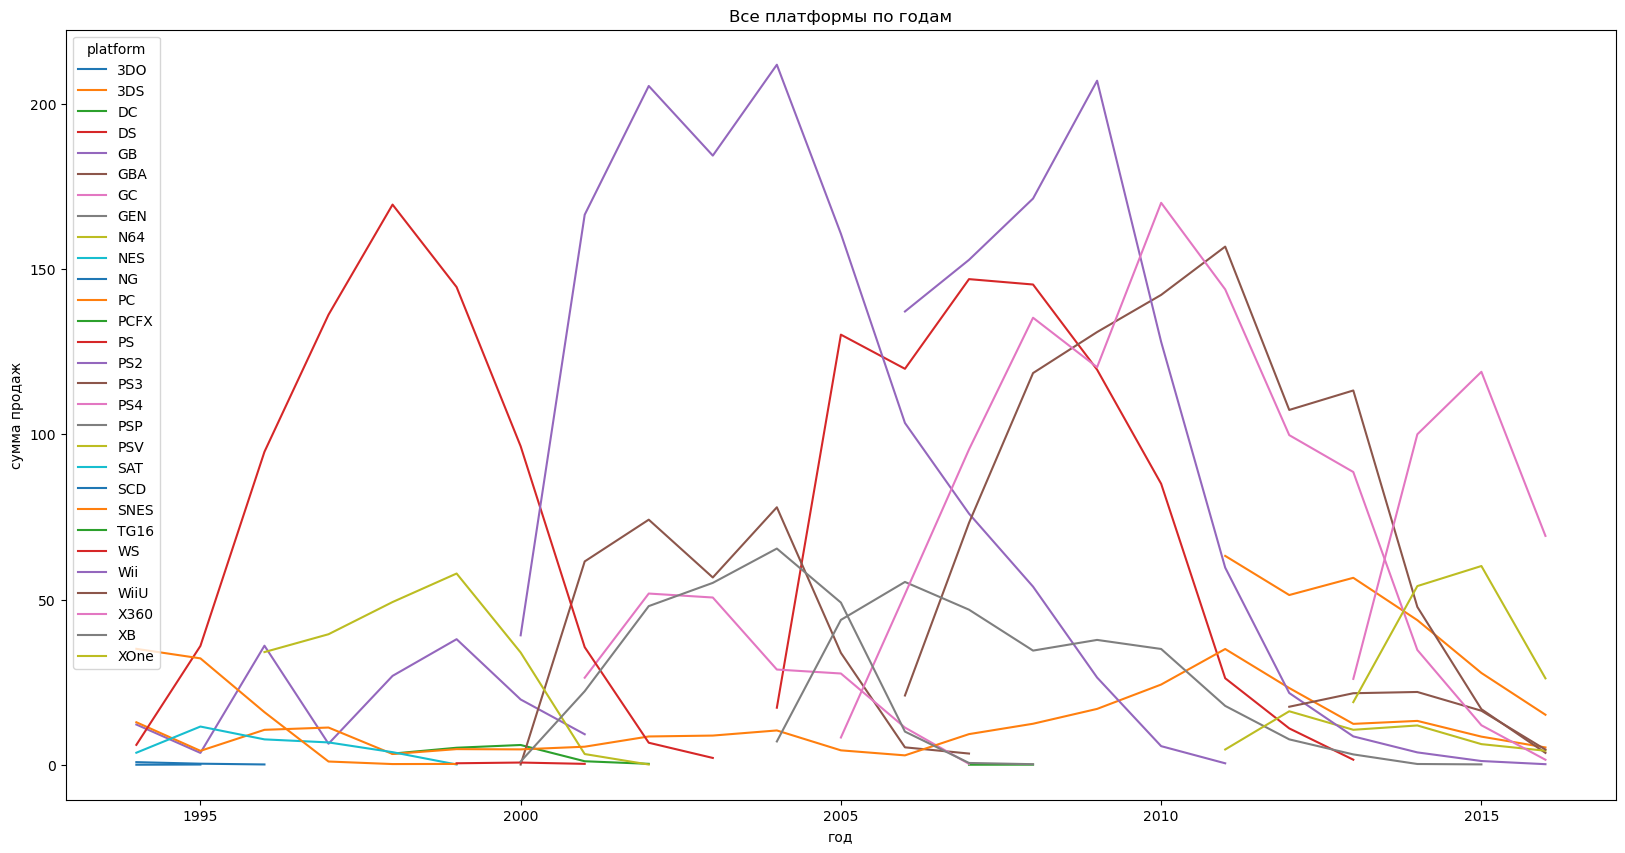

In [39]:
(games.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(20, 10)))
plt.title('Все платформы по годам')
plt.xlabel('год')
plt.ylabel('сумма продаж')
plt.show()

На графике всех платформ видим, что после 2011 года взлет был только у двух - Sony PS4 и Microsoft XOne, их продажи в разы меньше продаж топовых платформ. У всех остальных платформ с 2011 года тенденция к снижению продаж.

In [40]:
other_platforms_life = (games.query('platform != ["PS2", "X360", "PS3", "Wii", "DS", "PS"]')
    .pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']))
other_platforms_life.columns = ['release', 'end']
other_platforms_life['life'] = other_platforms_life.end - other_platforms_life.release
other_platforms_life.sort_values(by='release')

,release,end,life
platform,,,
3DO,1994,1995,1
SNES,1994,1999,5
GB,1994,2001,7
SCD,1994,1994,0
SAT,1994,1999,5
GEN,1994,1994,0
PC,1994,2016,22
NES,1994,1994,0
NG,1994,1996,2


Мы видим, что платформа PC для ПК - долгожитель (22 года), хоть продажи с нее в разы меньше топовых платформ (люди всегда играли и будут играть на компьютере). PSP - разновидность платформы от Sony, продолжительность характерна для топовых.

In [41]:
median_life = other_platforms_life.query('platform != "PC"')
median = median_life['life'].median()
print(f'Средняя продолжительность остальных платформ - {median} года.')

Средняя продолжительность остальных платформ - 4.5 года.


### Актуальный период

Игровая индустрия довольно быстро меняется, для прогноза на 2017 год возьмем последние 3 года, исходя из средней продолжительности жизни большинства платформ - 4.5 года и того факта, что её половина проходит в нисходящей тенденции продаж (за этот период мы точно увидим стадию взлета или спада продаж и сможем спрогнозировать развитие).  
Изначально хотели взять промежуток в 10 лет, что соответствует жизни топовых платформ, но на общем графике увидели, что за последние 5 лет только у двух не топовых платформ восходящие продажи, остальные и топовые патформы на спаде.

In [42]:
games_actual = games.query('year_of_release > 2013')

In [43]:
games_actual.groupby('year_of_release')['year_of_release'].count()

year_of_release
2014    581
2015    606
2016    502
Name: year_of_release, dtype: int64

Данные по годам распределены равномерно.

### Прибыльные платформы актуального периода

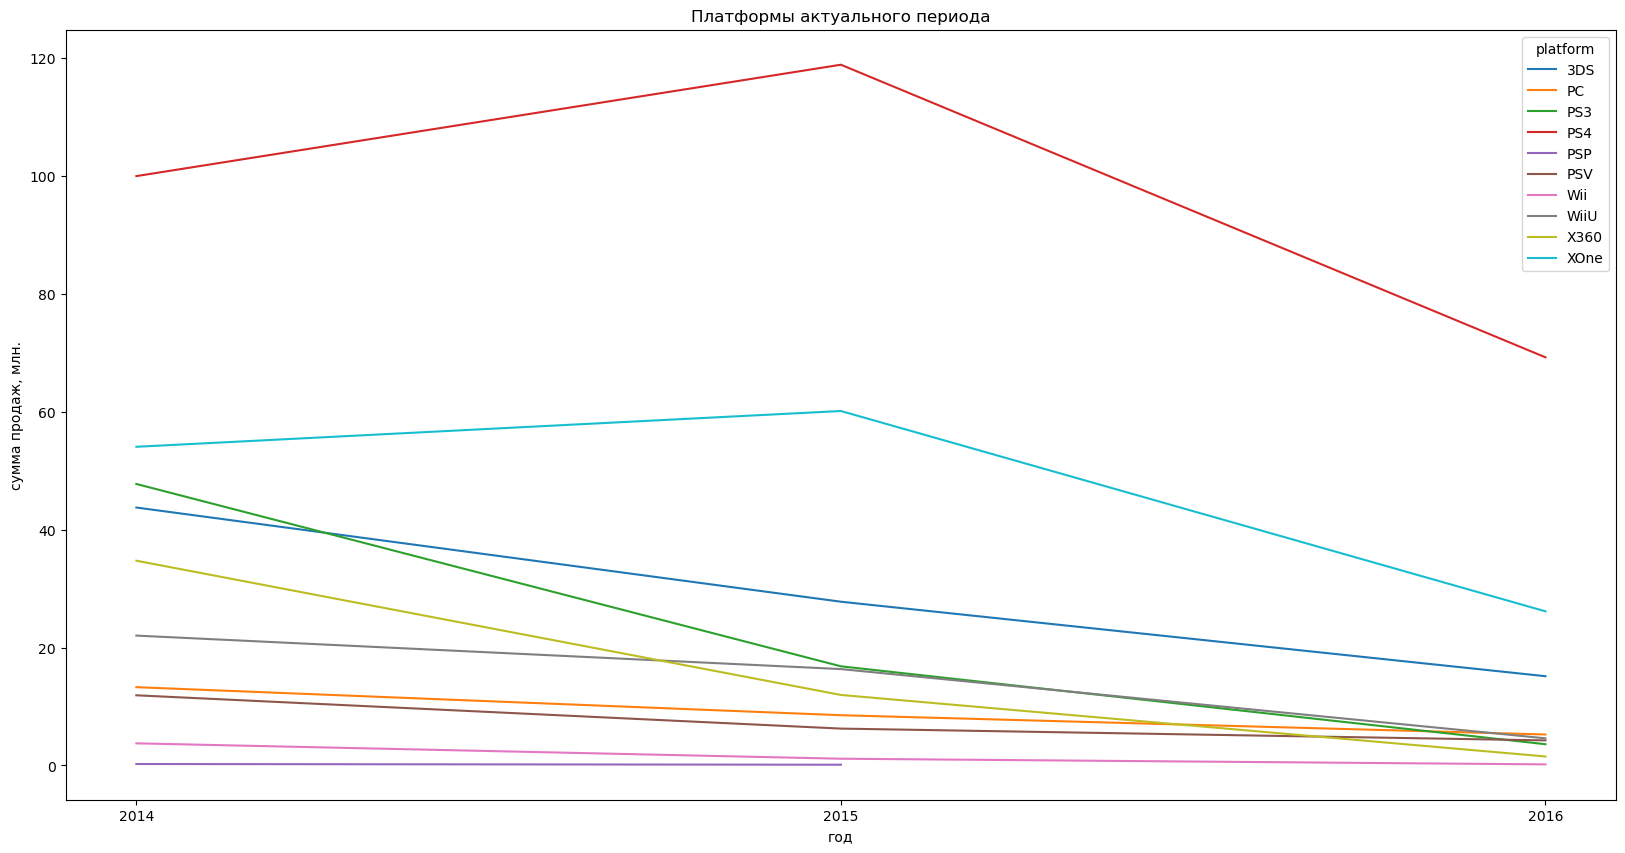

In [44]:
(games_actual.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(20, 10)))
plt.title('Платформы актуального периода')
plt.xlabel('год')
plt.ylabel('сумма продаж, млн.')
plt.xticks(range(2014, 2017))
plt.show()

Ещё на общем графике мы видели нисходящий тренд продаж всех платформ.  
Только две платформы - Sony PS4 и Microsoft XOne имеют пик в актуальном периоде 2013-2016 г., а значит проживут дольше остальных. К их показателям наиболее близки продажи платформы 3DS, её также можно считать более прибыльной, чем остальные.  
**К 2016 году продажи всех платформ идут на спад.**

Посмотрим на глобальные продажи по платформам.

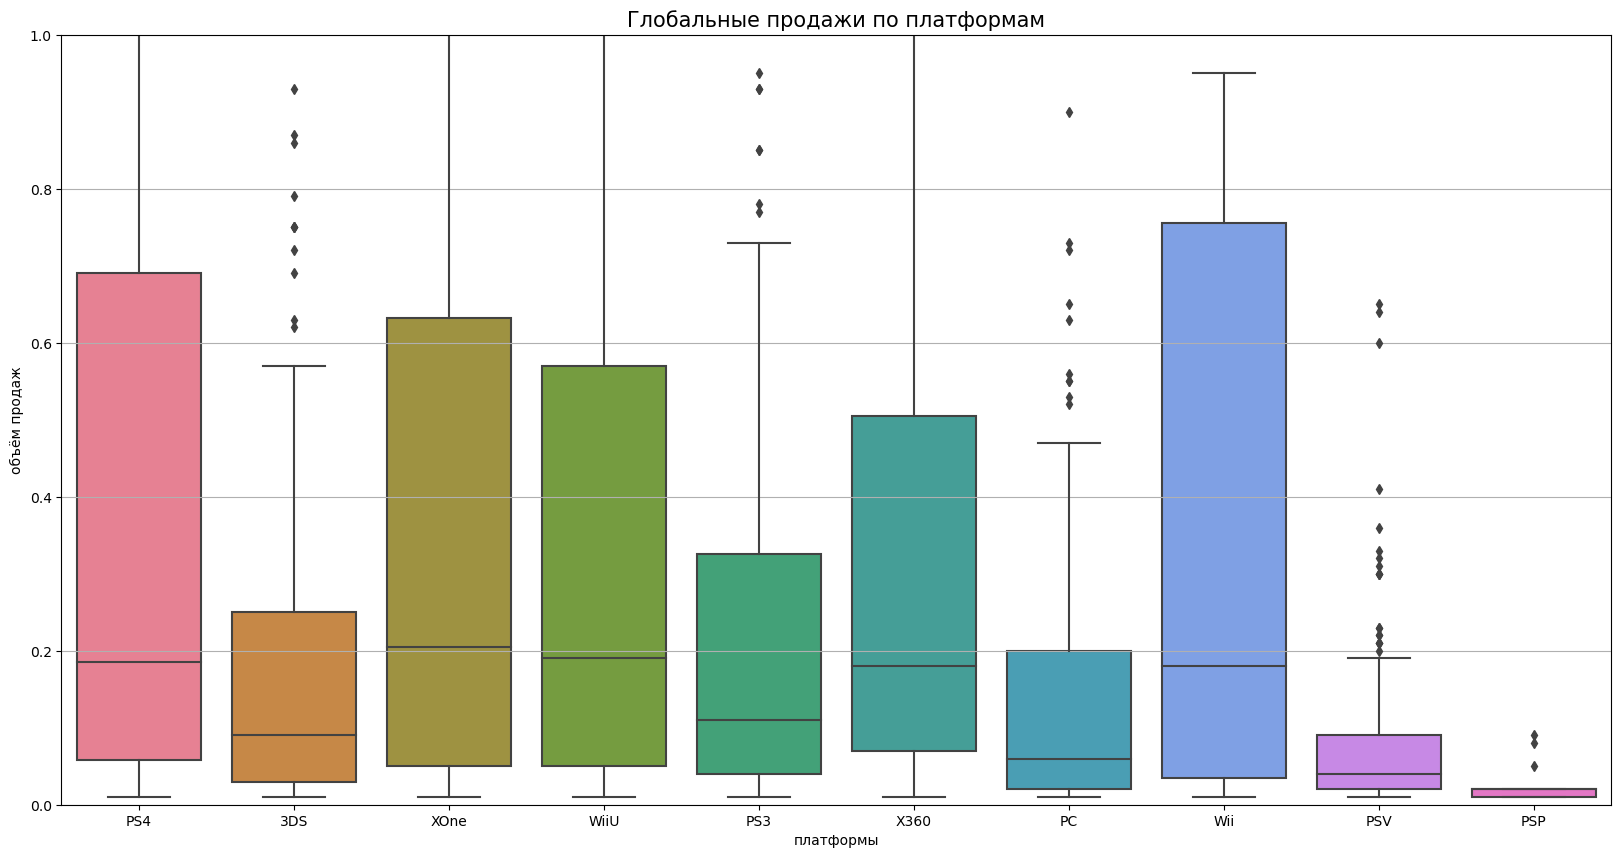

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid()
sns.boxplot(data=games_actual, x='platform', y='total_sales', palette='husl')
plt.title('Глобальные продажи по платформам', fontsize=15)
plt.xlabel('платформы')
plt.ylabel('объём продаж')
plt.ylim(0, 1)
plt.show()

Суммарные продажи:

In [46]:
games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: total_sales, dtype: float64

Наибольшее количество копий продано на платформах - **Wii, PS4, Xone, WiiU, X360** .  
В суммарных продажах по платформам с большим отрывом лидируют - **PS4 и XOne**. Возможно, на них влияют очень успешные игры.

### Влияние отзывов на продажи

Посмотрим зависимость объёма продаж от оценок критиков и пользователей для платформ актуального периода:

In [47]:
games_actual_corr = games_actual[['total_sales','critic_score','user_score']]

In [48]:
rs = np.random.RandomState(0)
correlation = pd.DataFrame(rs.rand(8, 8))
corr = games_actual_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,total_sales,critic_score,user_score
total_sales,1.000000,0.328105,-0.013070
critic_score,0.328105,1.000000,0.504460
user_score,-0.013070,0.504460,1.000000


На единой таблице корреляции не видно зависимости объема продаж от оценок пользователей, зависимость продаж от оценок критиков слабая.

Возмем самую прибыльную платформу актуального периода - **SP4**, и рассмотрим влияние отзывов и критиков на ее продажи.  
Построим диаграмму рассеяния.

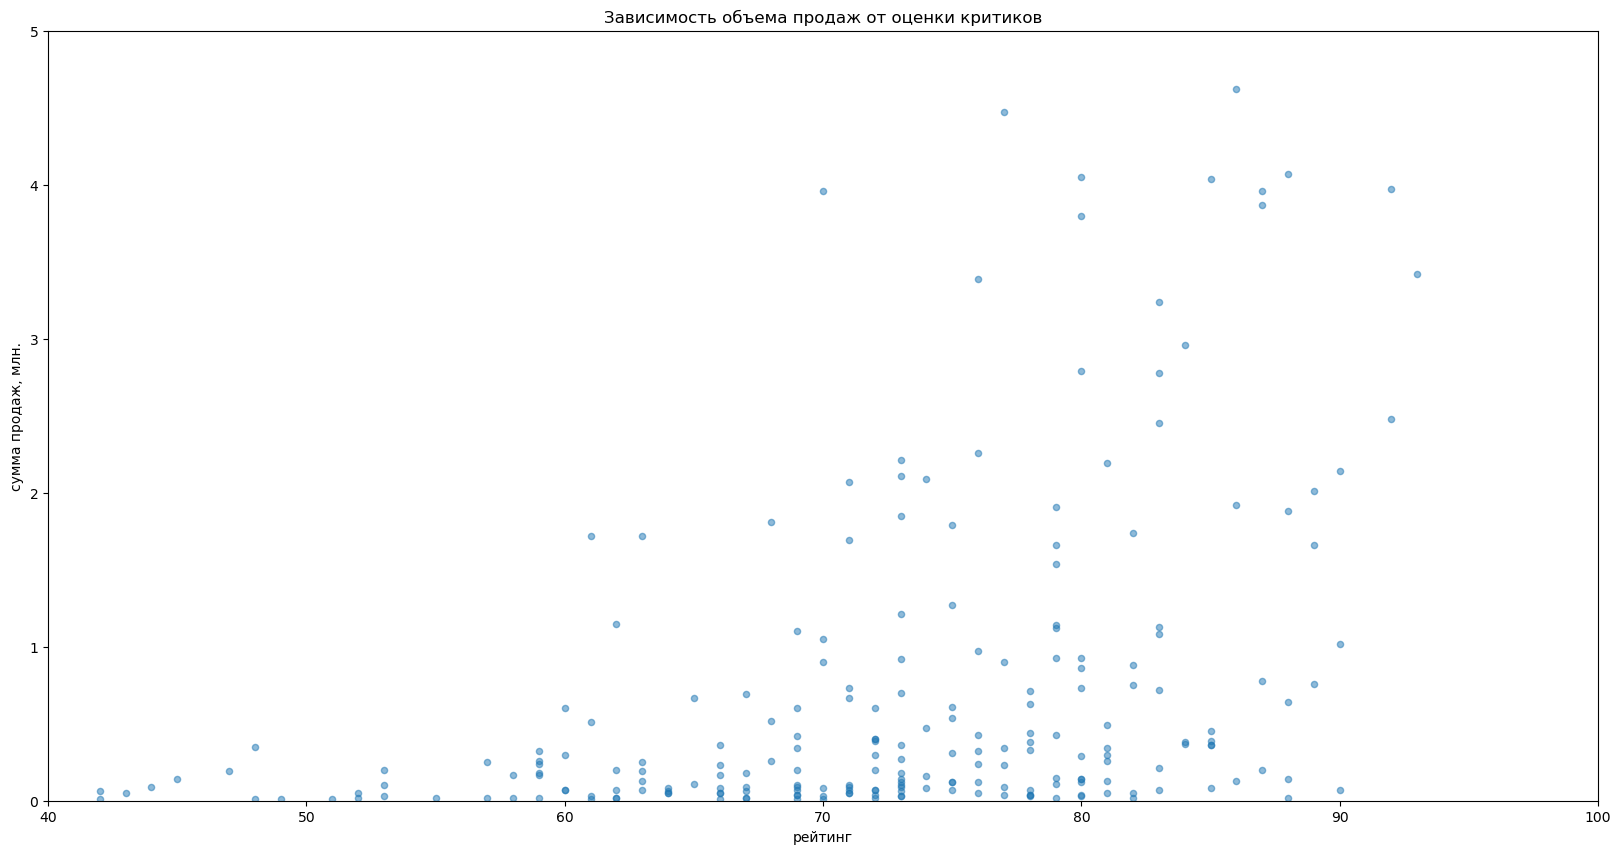

In [49]:
(games_actual.query('platform == "PS4"')
    .plot(x='critic_score', y='total_sales', kind='scatter', xlim=(40, 100), ylim=(0, 5), figsize=(20, 10), alpha=0.5))
plt.title('Зависимость объема продаж от оценки критиков')
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

Среди игр, получивших оценку до 80 баллов, случаи с большим объёмом продаж скорее похожи на выбросы, зависимость очень слабая. В то время как игры с оценкой более 80 баллов имеют равномерный разброс объем продаж, что говорит о том, что есть зависимость между объёмом продаж и высокой оценкой критиков (более 80 баллов).

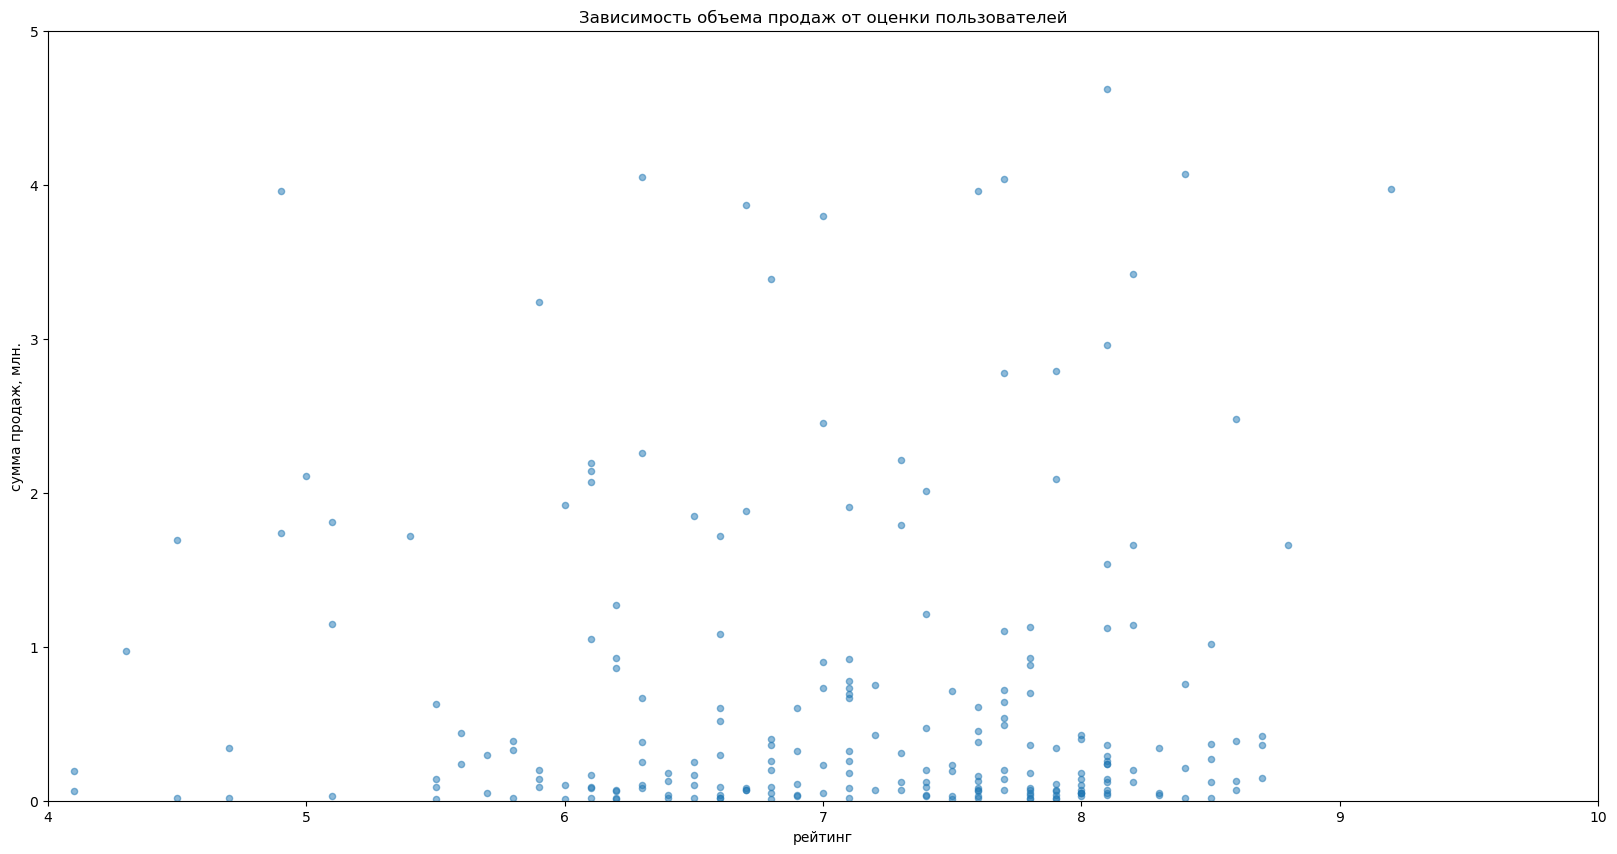

In [50]:
(games_actual.query('platform == "PS4"')
    .plot(x='user_score', y='total_sales', kind='scatter', xlim=(4, 10), ylim=(0, 5), figsize=(20, 10), alpha=0.5))
plt.title('Зависимость объема продаж от оценки пользователей')
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

Здесь мы видим равномерное распределение игр вдоль рейтинговой оси, и несколько выбросов на всем диапазоне. Зависимости объёмов продаж от оценки пользователей нет.

Сравним результат с двумя другими перспективныи платформами актуального периода - XOne и 3DS.

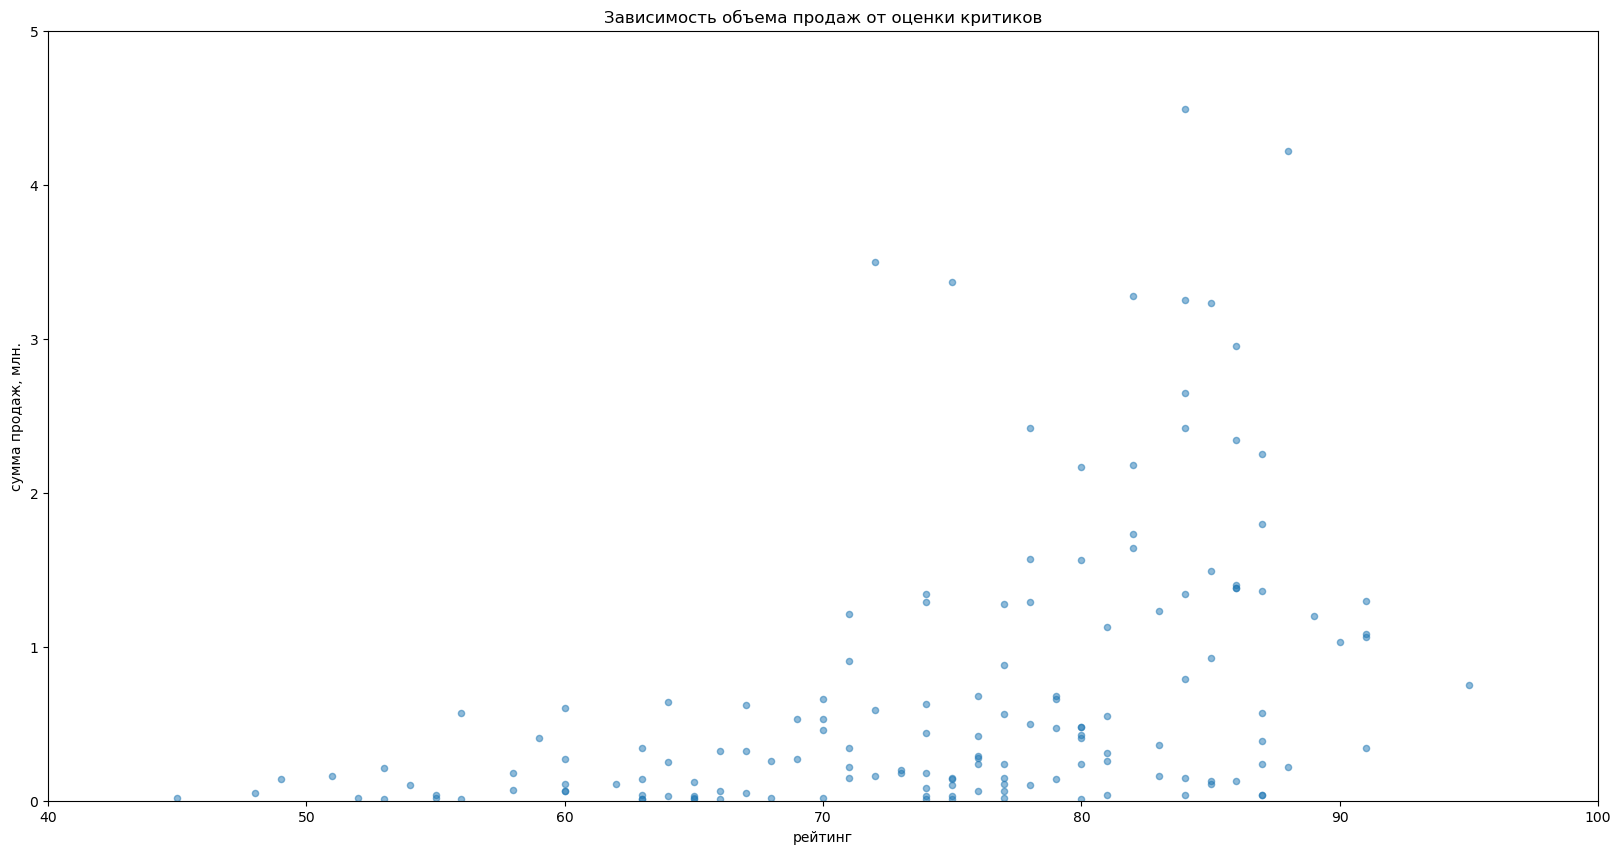

In [51]:
(games_actual.query('platform == "XOne"')
    .plot(x='critic_score', y='total_sales', kind='scatter', xlim=(40, 100), ylim=(0, 5), figsize=(20, 10), alpha=0.5))
plt.title('Зависимость объема продаж от оценки критиков')
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

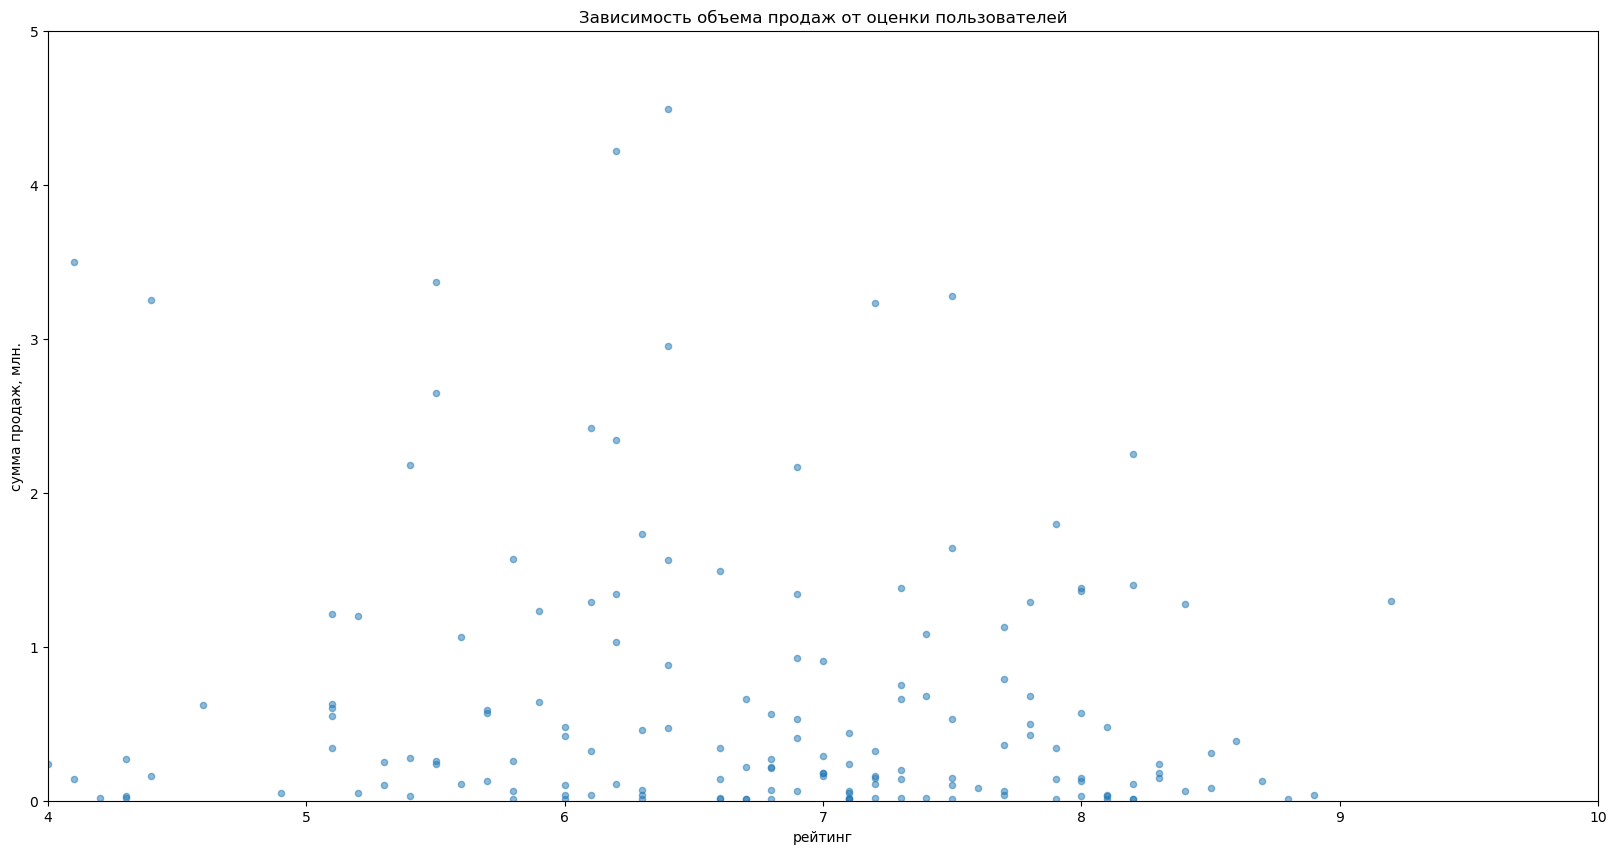

In [52]:
(games_actual.query('platform == "XOne"')
    .plot(x='user_score', y='total_sales', kind='scatter', xlim=(4, 10), ylim=(0, 5), figsize=(20, 10), alpha=0.5))
plt.title('Зависимость объема продаж от оценки пользователей')
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

Здесь мы видим такую же ситуацию, как с играми на платформе SP4 - зависимость объёмов продаж игр на платформе **XOne**  есть только с высокой оценкой критиков (более 80 баллов). 

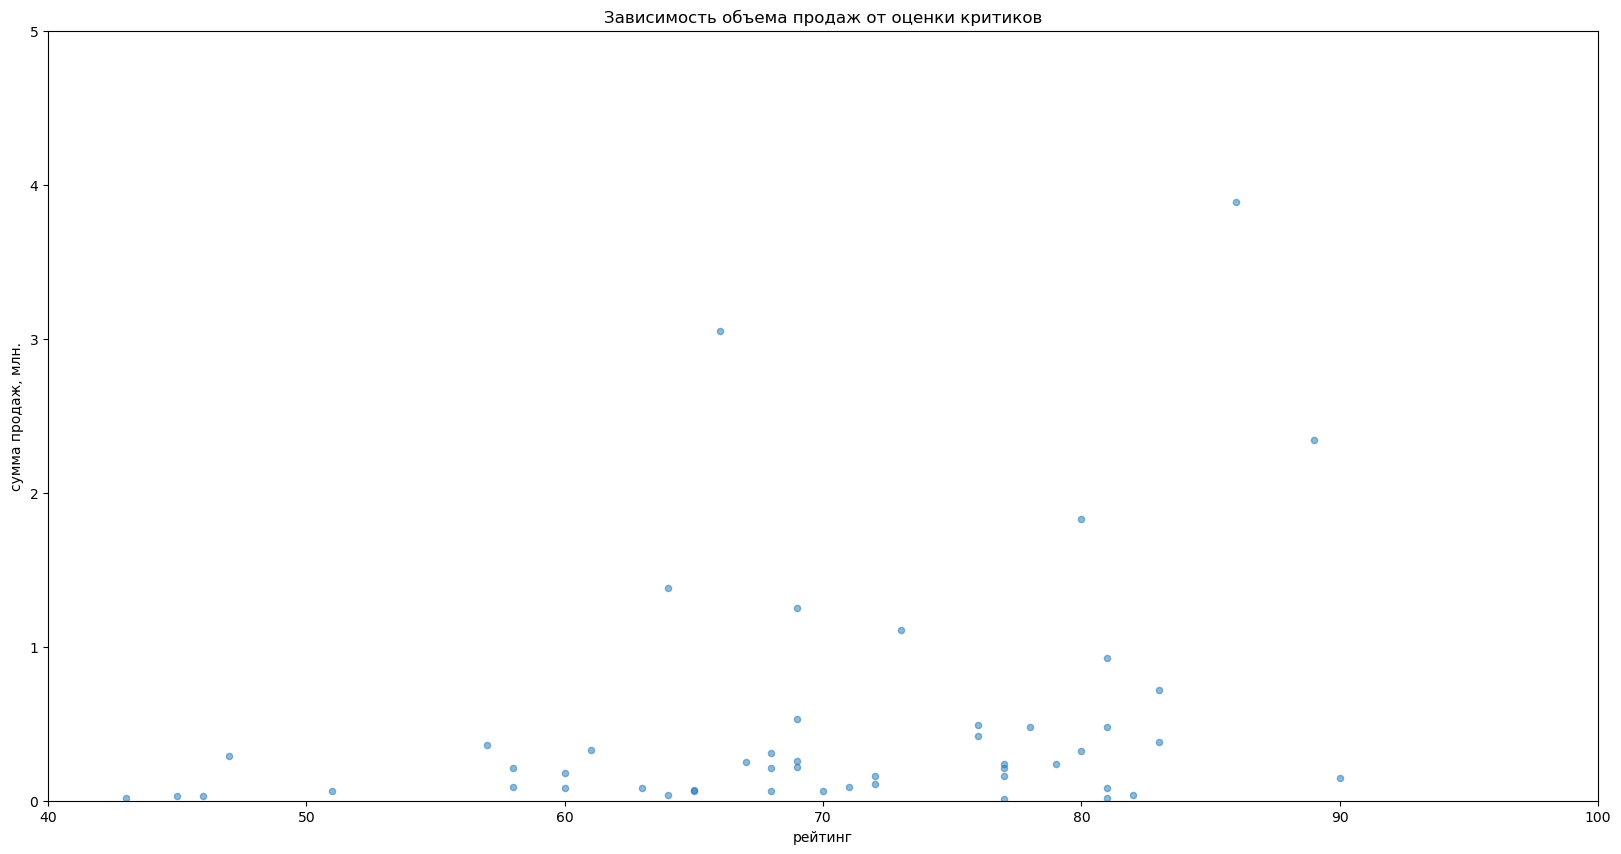

In [53]:
(games_actual.query('platform == "3DS"')
    .plot(x='critic_score', y='total_sales', kind='scatter', xlim=(40, 100), ylim=(0, 5), figsize=(20, 10), alpha=0.5))
plt.title('Зависимость объема продаж от оценки критиков')
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

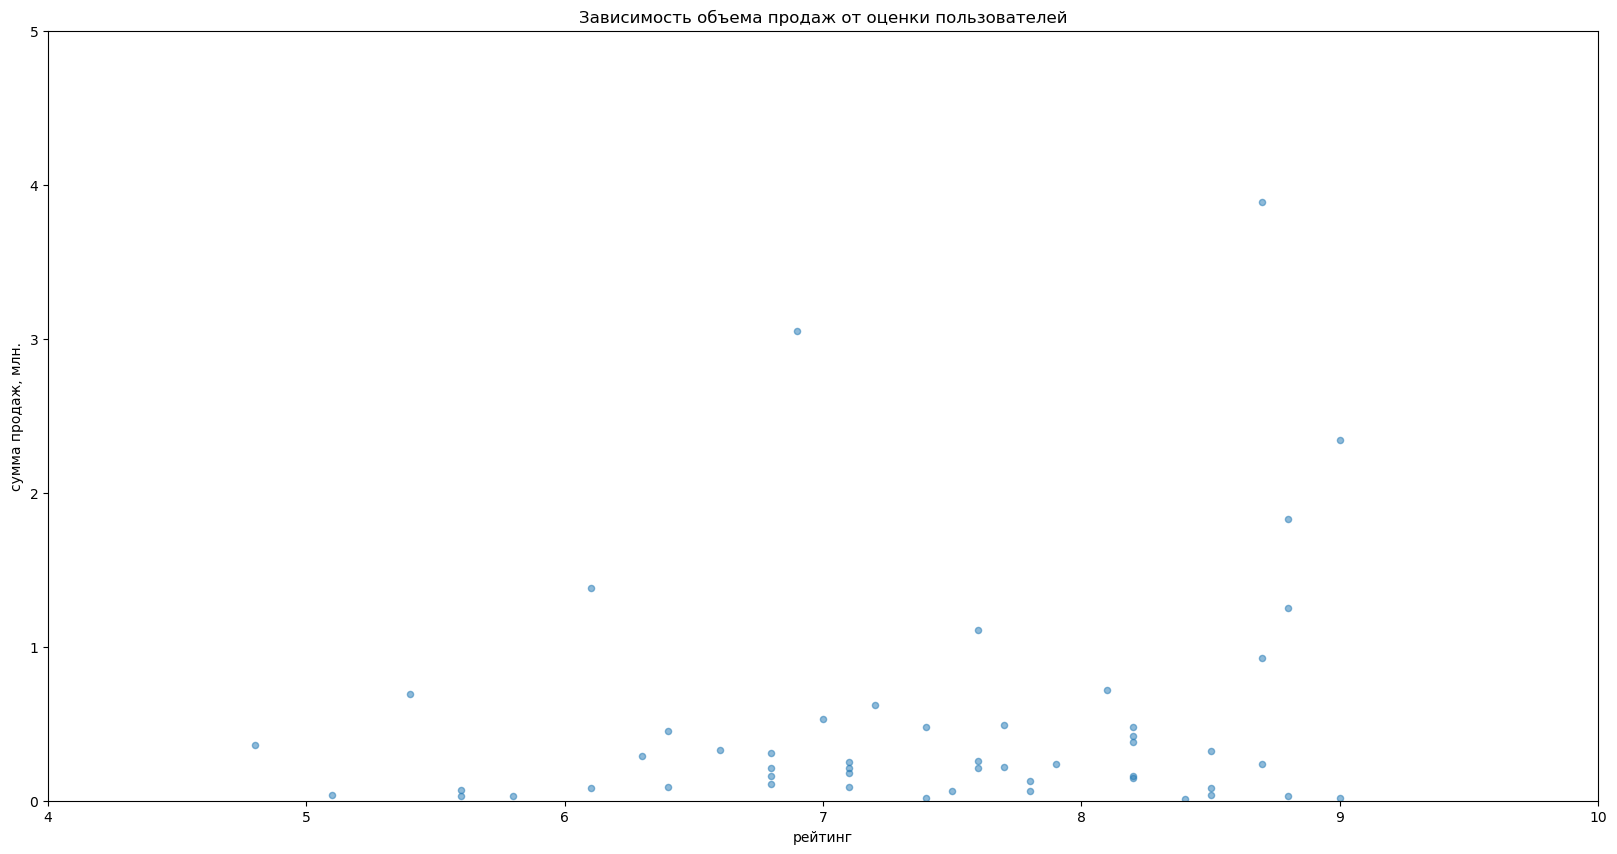

In [54]:
(games_actual.query('platform == "3DS"')
    .plot(x='user_score', y='total_sales', kind='scatter', xlim=(4, 10), ylim=(0, 5), figsize=(20, 10), alpha=0.5))
plt.title('Зависимость объема продаж от оценки пользователей')
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

In [55]:
p_3ds = games_actual.query('platform == "3DS"')
p_3ds[~p_3ds['critic_score'].isna()]['critic_score'].count()

51

Оценок игр от критиков и пользователей на платформе **3DS** слишком мало, чтобы по ним делать выводы.

### Влияние жанров на продажи

Визуализируем суммарные продажи по жанрам.

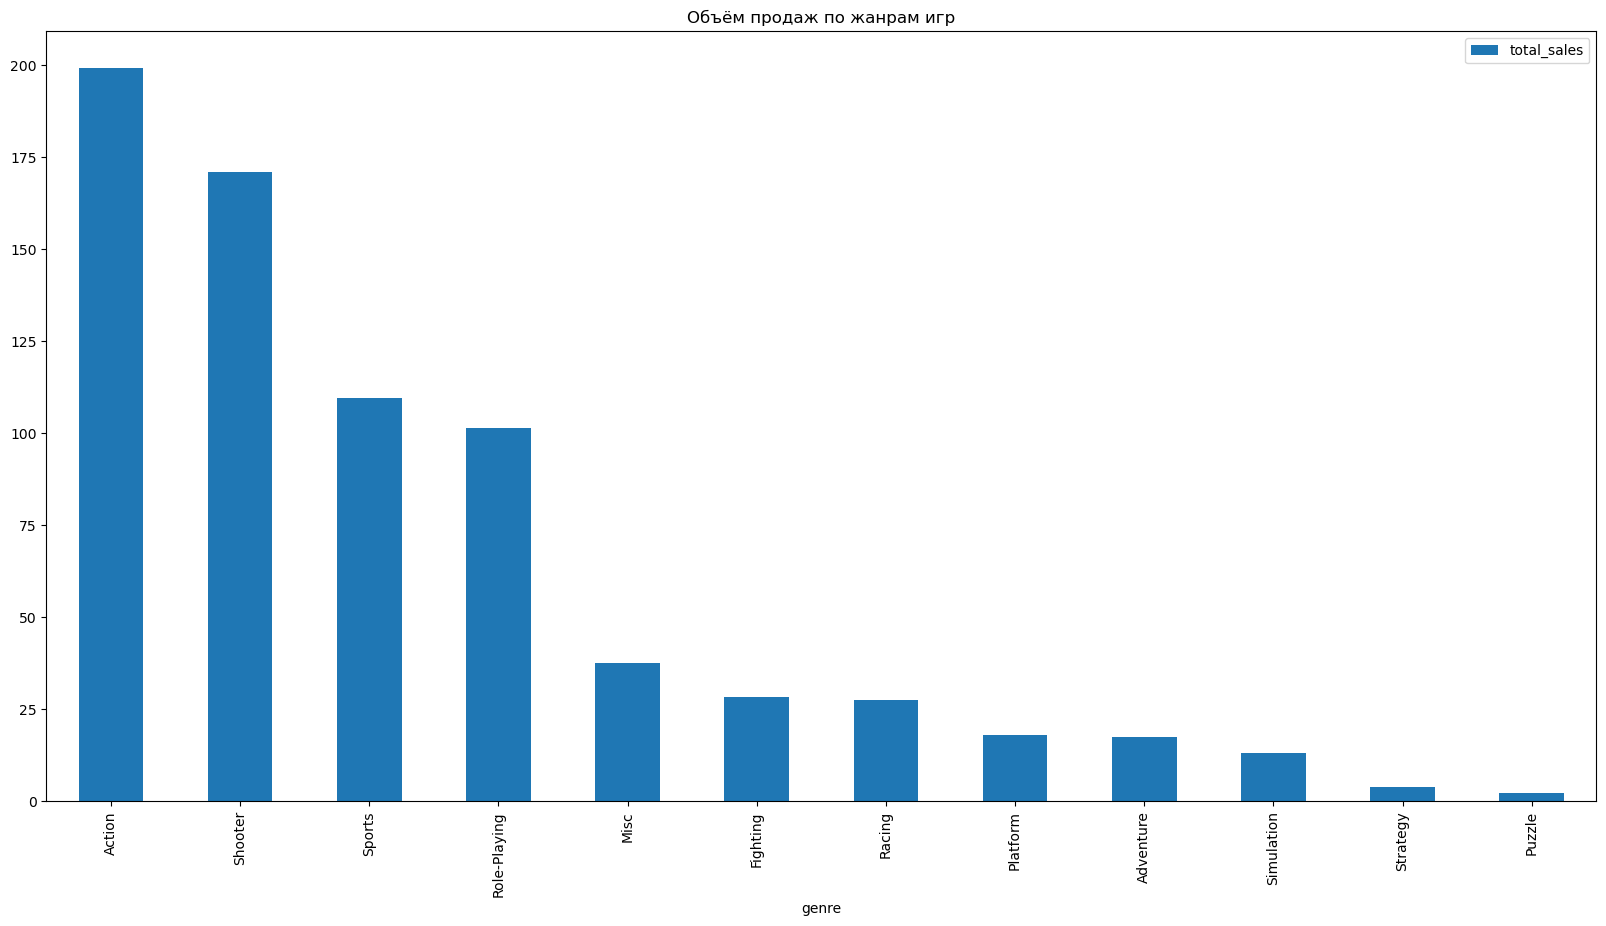

In [56]:
(games_actual.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
    .plot.bar(title='Объём продаж по жанрам игр', figsize=(20, 10)))
plt.show()

По общей сумме продаж самые прибыльные жанры - Action, Shooter, Sports и Misc. У них довольно сильный разрыв в продажах с остальными жанрами, Strategy и Puzzle - самые неприбыльные жанры.

Топ 10 самых прибыльных игр актуального периода и их жанры:

In [57]:
games_actual.pivot_table(index=['genre', 'name'], values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(10)

total_sales
genre        name                                            
Shooter      Call of Duty: Black Ops 3                  25.67
             Call of Duty: Advanced Warfare             21.97
Action       Grand Theft Auto V                         19.26
Sports       FIFA 15                                    17.37
             FIFA 16                                    16.30
Misc         Minecraft                                  14.98
Role-Playing Fallout 4                                  12.67
Shooter      Destiny                                    12.54
Fighting     Super Smash Bros. for Wii U and 3DS        12.42
Shooter      Star Wars Battlefront (2015)               12.19

Видно, что продажи некоторых игр занимают существенную долю от общих продаж жанра. Чтобы игры бестселлеры не искажали статистику пересчитаем прибыльность жанров по медиане продаж.

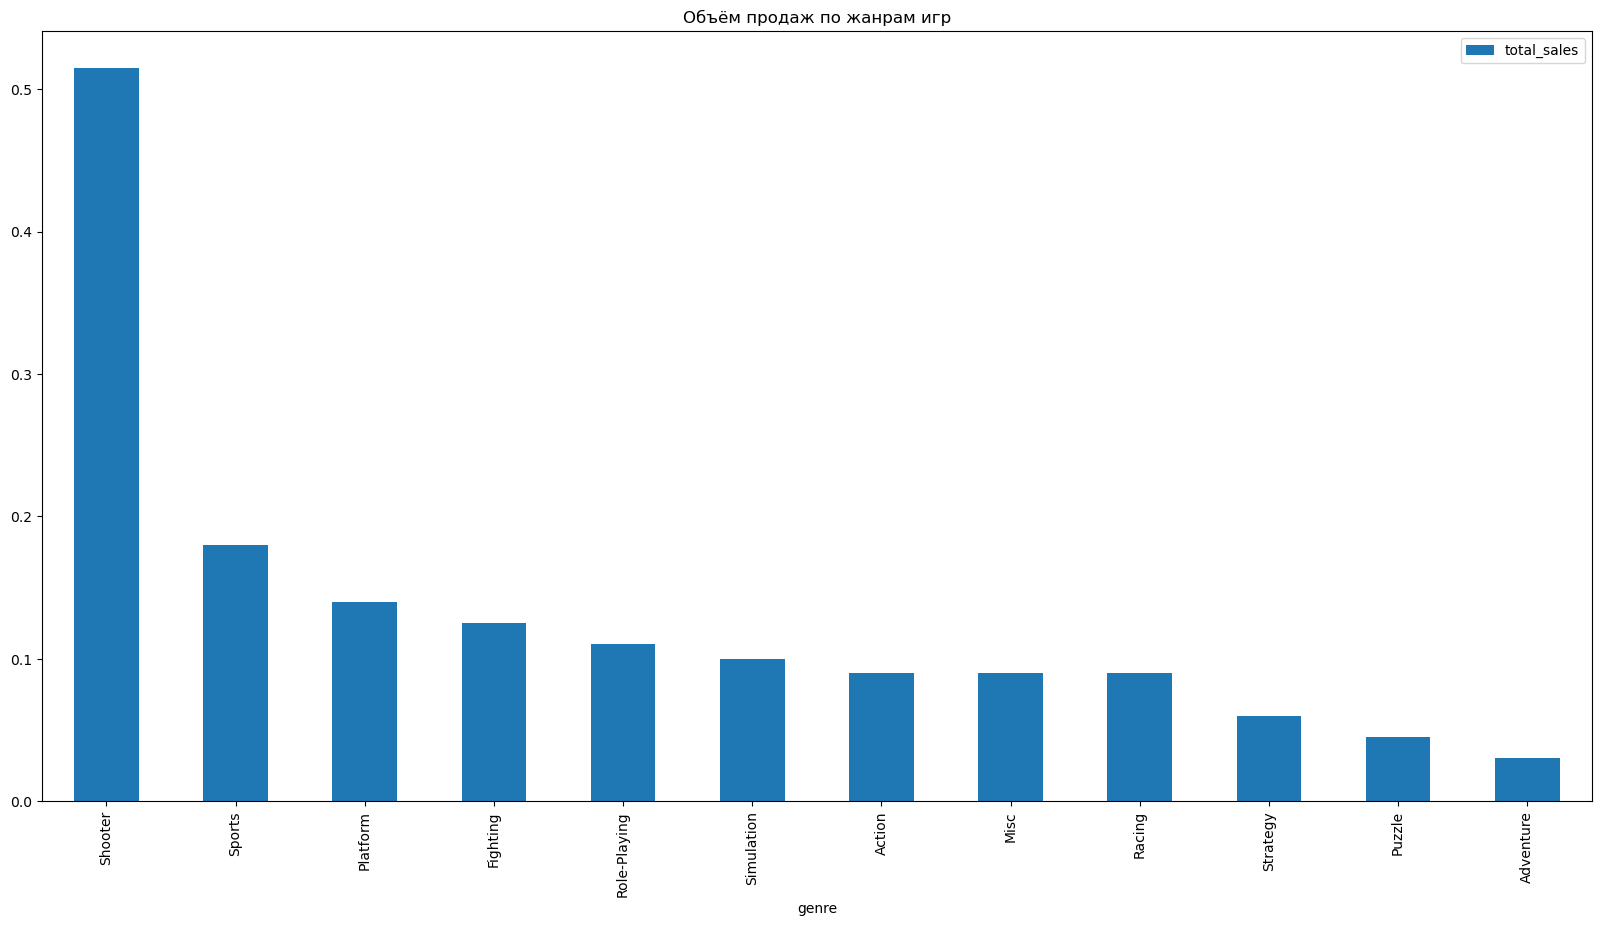

In [58]:
(games_actual.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False)
    .plot.bar(title='Объём продаж по жанрам игр', figsize=(20, 10)))
plt.show()

Мы получили совершенно другую картину, явный лидер продаж по медианной прибыльности игр - **Shooter**. 

Далее прибыльность плавно уменьшается. Самый не прибыльный жанр - **Adventure**.

## ПОРТРЕТ ПОЛЬЗОВАТЕЛЯ КАЖДОГО РЕГИОНА (NA, EU, JP)

### Самые популярные платформы

Для начала выведем по 10 топовых платформ в каждом регионе.

In [59]:
games_actual.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(10)

platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
WiiU    19.36
PC       7.23
PSV      2.52
Wii      2.08
PSP      0.00
Name: na_sales, dtype: float64

Отметим 6 топовых платформ в Северной Америке, поскольку между 5 и 6 местом разрыв очень маленький, а дальше продажи сильно отличаются.

In [60]:
games_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(10)

platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
X360     15.49
WiiU     13.15
PSV       3.53
Wii       2.59
PSP       0.00
Name: eu_sales, dtype: float64

В Европе можно выделить 7 топовых платформ. Остальные приносят в разы меньше продаж.

In [61]:
games_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(10)

platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
PSP      0.36
XOne     0.32
X360     0.08
PC       0.00
Wii      0.00
Name: jp_sales, dtype: float64

В Японии только 5 топовых платформ.

Мы видим, что в топе по регионам повторяются одни и те же платформы, но их прибыльность разная.  

**Итоги продаж по регионам:**  
- **PS4** - самая прибыльная в Европе и Северной Америке (причем продажи в Европе гораздо выше), на втором месте в Японии   
- **3DS** - на первом месте в Японии и в хвосте топовых платформ Северной Америки и Европы
- **XOne** - на втором месте в Северной Америке и Европе (продажи в Америке в два раза выше), и совсем не актуальна в Японии  
- **X360** - актуальна в Северной Америке и Европе, не актуальна в Японии
- **PC** - прибыльна в Европе, занимает последнее место в топ-6 Северной Америки и совсем не актуальна в Японии
- **PS3** и **WiiU** - входят в топ-7 всех регионов 


### Самые популярные жанры

Также выведем по 10 топовых жанров в каждом регионе.

In [62]:
games_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(10)

genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Fighting        12.43
Racing           8.74
Platform         6.79
Adventure        5.64
Simulation       2.63
Name: na_sales, dtype: float64

In [63]:
games_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(10)

genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Misc            12.86
Simulation       7.30
Platform         6.80
Fighting         6.69
Adventure        6.49
Name: eu_sales, dtype: float64

In [64]:
games_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(10)

genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Adventure        3.60
Sports           3.26
Platform         2.69
Simulation       2.31
Racing           1.76
Name: jp_sales, dtype: float64

Мы видим, что в Северной Америке и Европе можно выделить 6 топовых жанров, в то время как в Японии только два жанра имеют сильный разрыв с остальными.

**Итоги по жанрам в регионах:**  
- жанр **Action** - входит в топ-2 по прибыльности во всех регионах
- жанр **Role-Playing** на первом месте в Японии, но в других регионах занимает лишь 4 место в топе
- в Северной Америке и Европе топ 6 популярных жанров практически полностью пересекаются и имеют сопоставимую прибыльность
- в Японии только два жанра наиболее прибыльны

Мы можем выделить сильное отличие Японских предпочтений от других регионов. Популярность жанра Role-Playing можно объяснить тем, что большинство игр этого жанра разработано в Японии. Также есть интересная гипотеза, что ролевые игры уже становятся частью культуры Японии. Во-первых, они требуют ежедневной прокачки героя, что соответствует трудолюбию японцев. Во-вторых, в основе японского общества не критикуется ежедневное сидение за играми, а наоборот поощрается как социализация. И в-третьих, после долгого трудового дня японцам хочется расслабится - коллективные ролевые игры для этого отлично подходят (в других регионах трудовой день более нормирован). 

### Влияние рейтинга ESRB на продажи по регионам

In [65]:
games_actual.rating.unique()

array(['missing', 'M', 'E', 'T', 'E10+'], dtype=object)

В актуальном периоде есть 4 возрастных рейтинга:
- M - для взрослых (с 17 лет)
- T - для подростков (с 13 лет)
- E - для всех
- E10+ - для всех от 10 лет

"missing" - игры с отсутствующим рейтингом.

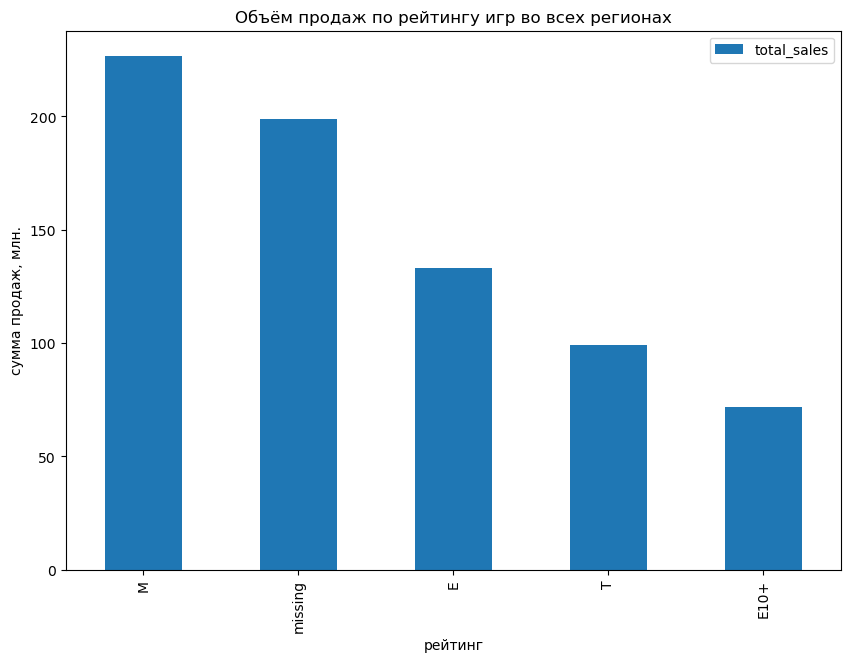

In [66]:
(games_actual.pivot_table(index='rating', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
    .plot.bar(title='Объём продаж по рейтингу игр во всех регионах', figsize=(10, 7)))
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

По всем регионам больше всего продаж в рейтинге **M** для взрослых.  
Игры с рейтингом **E10+** самые не прибыльные.

Теперь рассмотрим каждый в отдельности.

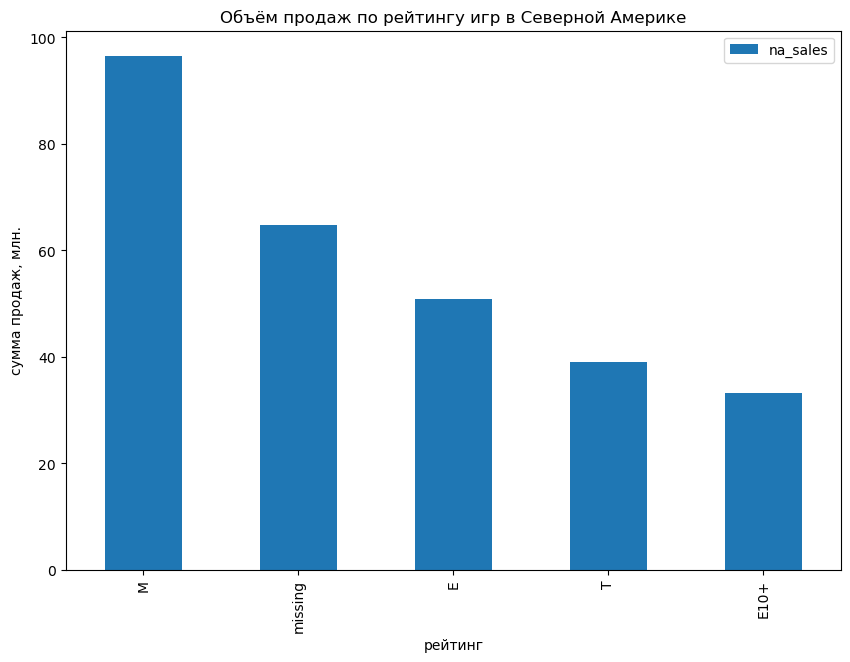

In [67]:
(games_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
    .plot.bar(title='Объём продаж по рейтингу игр в Северной Америке', figsize=(10, 7)))
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

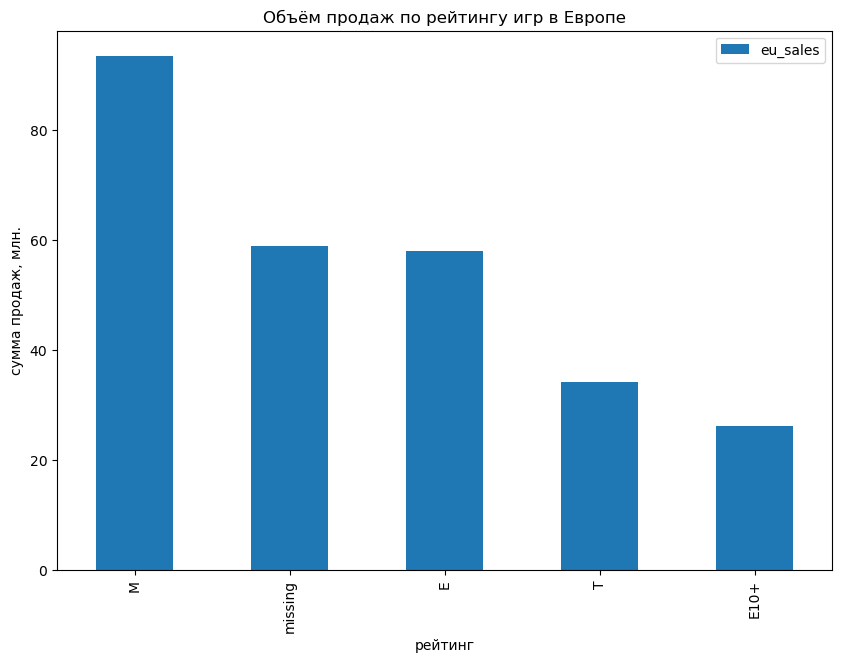

In [68]:
(games_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
    .plot.bar(title='Объём продаж по рейтингу игр в Европе', figsize=(10, 7)))
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

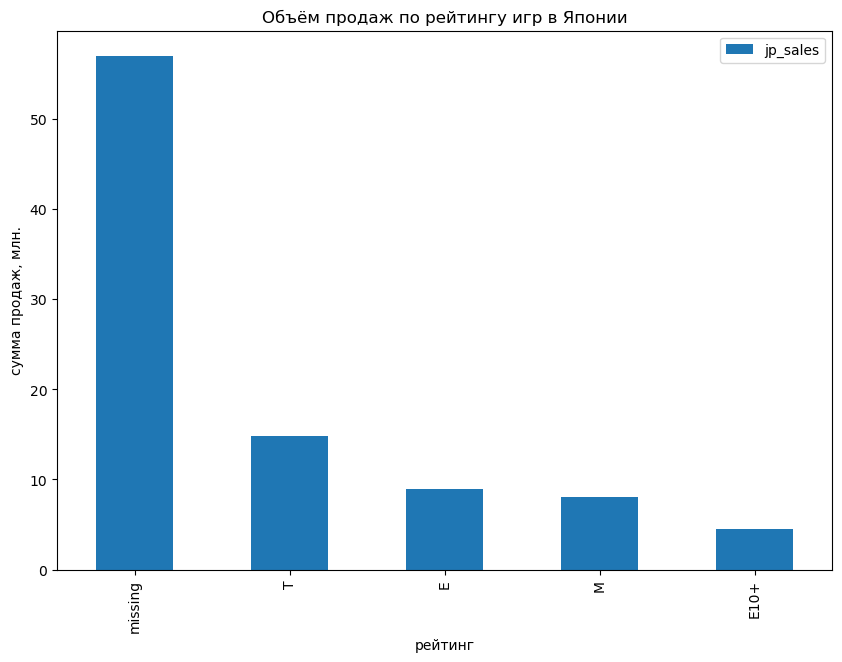

In [69]:
(games_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
    .plot.bar(title='Объём продаж по рейтингу игр в Японии', figsize=(10, 7)))
plt.xlabel('рейтинг')
plt.ylabel('сумма продаж, млн.')
plt.show()

Мы видим, Япония опять отличилась от тенденций других регионов. На первом месте с сильным отрывом по прибыльности в Японии идут игры с неопределенным рейтингом, второе место занимает рейтинг **T для подростков 13+**, а игры с рейтингом **M для взрослых** только на четвертом месте (в Северной Америке и Европе они на первом месте). Чтобы понять, почему в Японии так много игр без рейтинга, необходимы дополнительные исследования. Также, разрыв продаж по рейтингам в Японии менее заметен, чем в Северной Америке и Европе.  
Игры с рейтингом **E10+ для всех от 10 лет** самые не прибыльные.

**Вывод: есть сильная связь между рейтингом ESRB и регионом. В Северной Америке и Европе прибыльнее игры с рейтингом M, в Японии - с неопределенным рейтингом, рейтинг T для подростков 13+ на втором месте с существенным отрывом. Игры с рейтингом E10+  во всех регионах самые не прибыльные.**

## ПРОВЕРКА ГИПОТЕЗ

### Гипотеза №1 - рейтинги

Гипотеза №1 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [70]:
xone_score = games_actual.loc[(games_actual['platform'] == 'XOne') & (~games_actual['user_score'].isna())]
xone_score = xone_score.user_score

In [71]:
pc_score = games_actual.loc[(games_actual['platform'] == 'PC') & (~games_actual['user_score'].isna())]
pc_score = pc_score.user_score

In [72]:
alpha = 0.05

In [73]:
results = st.ttest_ind(xone_score, pc_score, equal_var=False)
print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('\033[1mОтвергаем нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC не равны\033[0m')
else:
    print('\033[1mНе получилось отвергнуть нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.\033[0m')

р-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.


Проверим результат для себя - найдем среднее значение пользовательских рейтингов по каждой платформе:

In [74]:
mean_xone = games_actual.query('platform == "XOne"')
mean_xone_score = np.around((mean_xone.user_score.mean()), decimals=1)
mean_xone_score_m = np.around((mean_xone.user_score.median()), decimals=1)
print(mean_xone_score)
print(mean_xone_score_m)

6.6
6.8


In [75]:
mean_pc = games_actual.query('platform == "PC"')
mean_pc_score = np.around((mean_pc.user_score.mean()), decimals = 1)
mean_pc_score_m = np.around((mean_pc.user_score.median()), decimals = 1)
print(mean_pc_score)
print(mean_pc_score_m)

6.3
6.8


Рейтинги пользователей платформ Xbox One и PC действительно очень похожи - средние значения близкие, медианы равны.

### Гипотеза №2 - жанры

Поскольку нулевая гипотеза всегда предполагает равенство - переформулируем предложенную гипотезу на обратную:

Гипотеза №2 - средние пользовательские рейтинги жанров Action и Sports равны.

In [76]:
action_score = games_actual.loc[(games_actual['genre'] == 'Action') & (~games_actual['user_score'].isna())]
action_score = action_score.user_score

In [77]:
sports_score = games_actual.loc[(games_actual['genre'] == 'Sports') & (~games_actual['user_score'].isna())]
sports_score = sports_score.user_score

In [78]:
results = st.ttest_ind(action_score, sports_score, equal_var=False)
print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('\033[1mОтвергаем нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports разные.\033[0m')
else:
    print('\033[1mНе получилось отвергнуть нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports равны.\033[0m')

р-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports разные.


Проверим результат для себя - найдем среднее значение пользовательских рейтингов по каждому жанру:

In [79]:
mean_action = games_actual.query('genre == "Action"')
mean_action_score = np.around((mean_action.user_score.mean()), decimals=1)
mean_action_score_m = np.around((mean_action.user_score.median()), decimals=1)
print(mean_action_score)
print(mean_action_score_m)

6.8
7.1


In [80]:
mean_sports = games_actual.query('genre == "Sports"')
mean_sports_score = np.around((mean_sports.user_score.mean()), decimals=1)
mean_sports_score_m = np.around((mean_sports.user_score.median()), decimals=1)
print(mean_sports_score)
print(mean_sports_score_m)

5.2
5.5


Действительно, и среднии значения и медианы сильно отличаются.

## ОБЩИЙ ВЫВОД

Мы провели исследовательский анализ данных компьютерных игр с 1980 по 2015 года.  
Сначала подготовили данные - оформили названия, обработали пропуски, проверили дубликаты, добавили столбец суммарных продаж по всем регионам. На первых гистограммах увидели:
- с 1990-х годов количество произведенных игр в разы увеличилось, пик приходится на 2010-е, далее до 2016 сильный спад 
- лидерами продаж является Северная Америка, затем, Европа и меньше всего продаж в Японии (другие страны в сумме сравнимы с продажами в Японии)
- средняя оценка игр критиками 65-85 баллов из ста.

На начальном этапе исследовательского анализа мы отсеяли часть данных до 1994 года, поскольку на раннем этапе развития игровой индустрии данных для анализа по годам слишком мало (менее 70 в год).  
Мы увидили интересную закономерность, что с 2010 года количество игр и платформ пошло на спад, а к 2016 году уменьшилось почти в три раза! Возможно, их вытесняют игры на смартфонах (на базе Android, IOS и т.п.).  

**Жизнь платформ**  
Топ 6 платформ за весь период во всех регионах - **PS2, X360, PS3, Wii, DS, PS**. Их средняя продолжительность 10 лет. Есть закономерность, что половина жизни топовых платформ проходит в росте продаж, половина на спаде. Жизнь остальных платформ проходит менее симметрично и занимает в среднем всего 4,5 года.  
Платформа **PC** для ПК - уникальный долгожитель (22 года), это классика, хоть продажи с неё в разы меньше топовых платформ.

Компании, разрабатывающие платформы придерживаются разной маркетинговой стратегии: Sony выпускала новую версию платформы после спада предыдущей, в отличие от Nintendo, она выпустила две платформы с разницой всего лишь в 2 года и на пике продаж первой.

**Прогноз на 2017 год**  
Для прогнозирования на 2017 год мы оставили данные за последние три года. В этом диапазоне только две платформы - **Sony PS4 и Microsoft XOne** имеют пик в актуальном периоде 2013-2016 г., а значит проживут дольше остальных (все остальные идут на спад). К их показателям близки продажи платформы **3DS**, её также можно считать прибыльнее остальных.

В суммарных продажах по платформам с большим отрывом лидируют - **PS4 и XOne** .   
Наибольшее количество копий продано на платформах - **Wii, PS4, Xone, WiiU, X360**.  

**Влияние отзывов на продажи**  
На единой таблице корреляции по всем регионам не видно зависимости объема продаж от оценок пользователей, зависимость продаж от оценок критиков слабая. У топовых платформ SP4 и XOne наблюдается зависимость между объёмом продаж и именно высокой оценкой критиков (более 80 баллов), зависимость объема продаж от оценок пользователей также нет. 

**Жанры**  
- **Shooter** - самые прибыльные жанр, с большим отрывом от остальных.
- **Adventure и Puzzle** - самые неприбыльные жанры.  

Игра может также выстрелить в жанрах **Action, Sports и Misc**, но на это сильно влияют и другие факторы.

**Портрет пользователя по регионам (NA, EU, JP)**  

Платформы:    
- **PS4** - самая прибыльная в Европе и Северной Америке (причем продажи в Европе гораздо выше), на втором месте в Японии   
- **3DS** - на первом месте в Японии и в хвосте топовых платформ Северной Америки и Европы
- **XOne** - на втором месте в Северной Америке и Европе (продажи в Америке в два раза выше), и совсем не актуальна в Японии  
- **X360** - актуальна в Северной Америке и Европе, не актуальна в Японии
- **PC** - прибыльна в Европе, занимает последнее место в топ-6 Северной Америки и совсем не актуальна в Японии
- **PS3** и **WiiU** - входят в топ-7 всех регионов 

Жанры:  
- жанр **Action** - входит в топ-2 по прибыльности во всех регионах
- жанр **Role-Playing** на первом месте в Японии, но в других регионах занимает лишь 4 место в топе
- в Северной Америке и Европе топ 6 популярных жанров практически полностью пересекаются и имеют сопоставимую прибыльность
- в Японии только два жанра наиболее прибыльны  

В Северной Америке и Европе можно выделить 6 топовых жанров, в то время как в Японии только 2 жанра имеют сильный разрыв с остальными.

**Влияние рейтинга ESRB на продажи**  
Есть сильная взаимосвязь между рейтингом ESRB и регионом.  
По всем регионам больше всего продаж игр с рейтингом **M** для взрослых.  
Игры с рейтингом **E10+** самые не прибыльные.  
- **M для взрослых** - самый прибыльный рейтинг игр в Северной Америке и Европе  
- **игры с неопределенным рейтингом** - самые прибыльные в Японии, на втором месте **Т для подростков 13+**.  

В Северной Америке и Европе рейтинги сильнее влияют на объём продаж, чем в Японии.

**Проверка гипотез**  
Первая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые - подтвердилась.  
Вторая гипотеза - средние пользовательские рейтинги жанров Action и Sports равны - опроверглась, рейтинги разные.

В завершении, для разработки успешной игры стоит выбирать популярный жанр и платформу, соответствующие региону продаж.  
Необходимо учитывать отличия Японского рынка от Европейского и Американского. Для Японии стоит провести дополнительные исследования по определению самого прибыльного возрастного рейтинга.  
Сильный спад популярности всех платформ и количества игр после 2010 года вызывает интерес и повод для дальнейших исследований. Возможно, стоит рассмотрить другие форматы игр (например игры для смартфонов на базе Android, IOS и т.п.).